# Capstone Project - Credit Card Fraud Detection

#### The project here is to predict the fraudulent credit card transactions with the help of machine learning models. The dataset is taken from the Kaggle website in the name of ‘Creditcard’ which is a ‘.csv’ file. The data set includes credit card transactions made by European cardholders over a period of two days in September 2013. This data set is highly unbalanced with the positive class (frauds) accounting for 0.172% of the total transactions. The data set has also been modified with Principal Component Analysis (PCA) to maintain confidentiality. Apart from ‘time’ , ‘amount’, and ‘Class’ all the other features (V1, V2, up to V28) are the principal components obtained using PCA. The class is the column which holds data whether a transaction is fraudulent or not. 

From the dataset it’s clear that the data is highly imbalanced, hence we can’t take the data directly for modeling. 
As the data is imbalanced, we need to use stratified k-fold cross validation but as the dataset is huge it will take too much time if we run it on the ordinary system, here for faster processing we use Google Colab or Nimble box.
The whole process is divided into 5 steps:
1. Data Understanding
2. Exploratory data analytics (EDA)
3. Train/Test Split
4. Model-Building/Hyperparameter Tuning
5. Model Evaluation

In [2]:
## installing the packages which are required to download the dataset from google drive to google Colab.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
## linking the drive and pasting the path so as to connect the drive to colab
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
# replace the id with id of file you want to access
downloaded = drive.CreateFile({'id':'10S1H4Obx39gsZd7QR0tMs0w80xLO5x9L'}) 
downloaded.GetContentFile('creditcard.csv')

In [2]:
## ---- for importing data in PC
## import pandas as pd
## credit_data = pd.read_csv("C:/Users/Sharath Jois/Downloads/creditcard.csv")

In [1]:
## --- For importing the dataset in Nimble box
# import pandas as pd
# credit_data = pd.read_csv('creditcard.csv') 

In [5]:
## taking the head of the dataset
credit_data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
# importing the libraries required for the future processes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import log_loss
from datetime import datetime as dt
from sklearn import metrics
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import PowerTransformer

import warnings
warnings.filterwarnings("ignore")

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
# checking the columns in the dataset
print([i for i in credit_data.columns])

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [8]:
# Checking the mean, std, min, max of the original dataset
credit_data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
# checking the datatype of each columns from the dataset
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

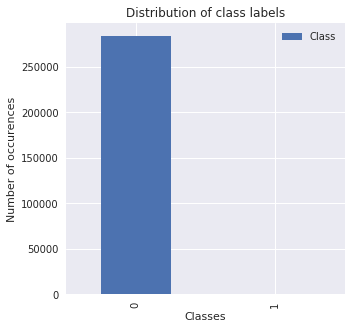

In [9]:
## Checking the class distribution by plotting a bar charta
credit_data['Class'].value_counts().plot(figsize=(5,5),kind='bar',legend='True')
plt.title("Distribution of class labels")
plt.xlabel("Classes")
plt.ylabel("Number of occurences")
plt.show()

In [10]:
# We can see that he dataset is not balanced
not_fraud=credit_data[credit_data['Class']==0].shape[0]
fraud=credit_data[credit_data['Class']==1].shape[0]
total=fraud+not_fraud

print("Percentage of Fradulent transaction: {}".format(np.round(100*fraud/total,4)))
print("Percentage of Non Fradulent transaction: {}".format(np.round(100*not_fraud/total,4)))

Percentage of Fradulent transaction: 0.1727
Percentage of Non Fradulent transaction: 99.8273


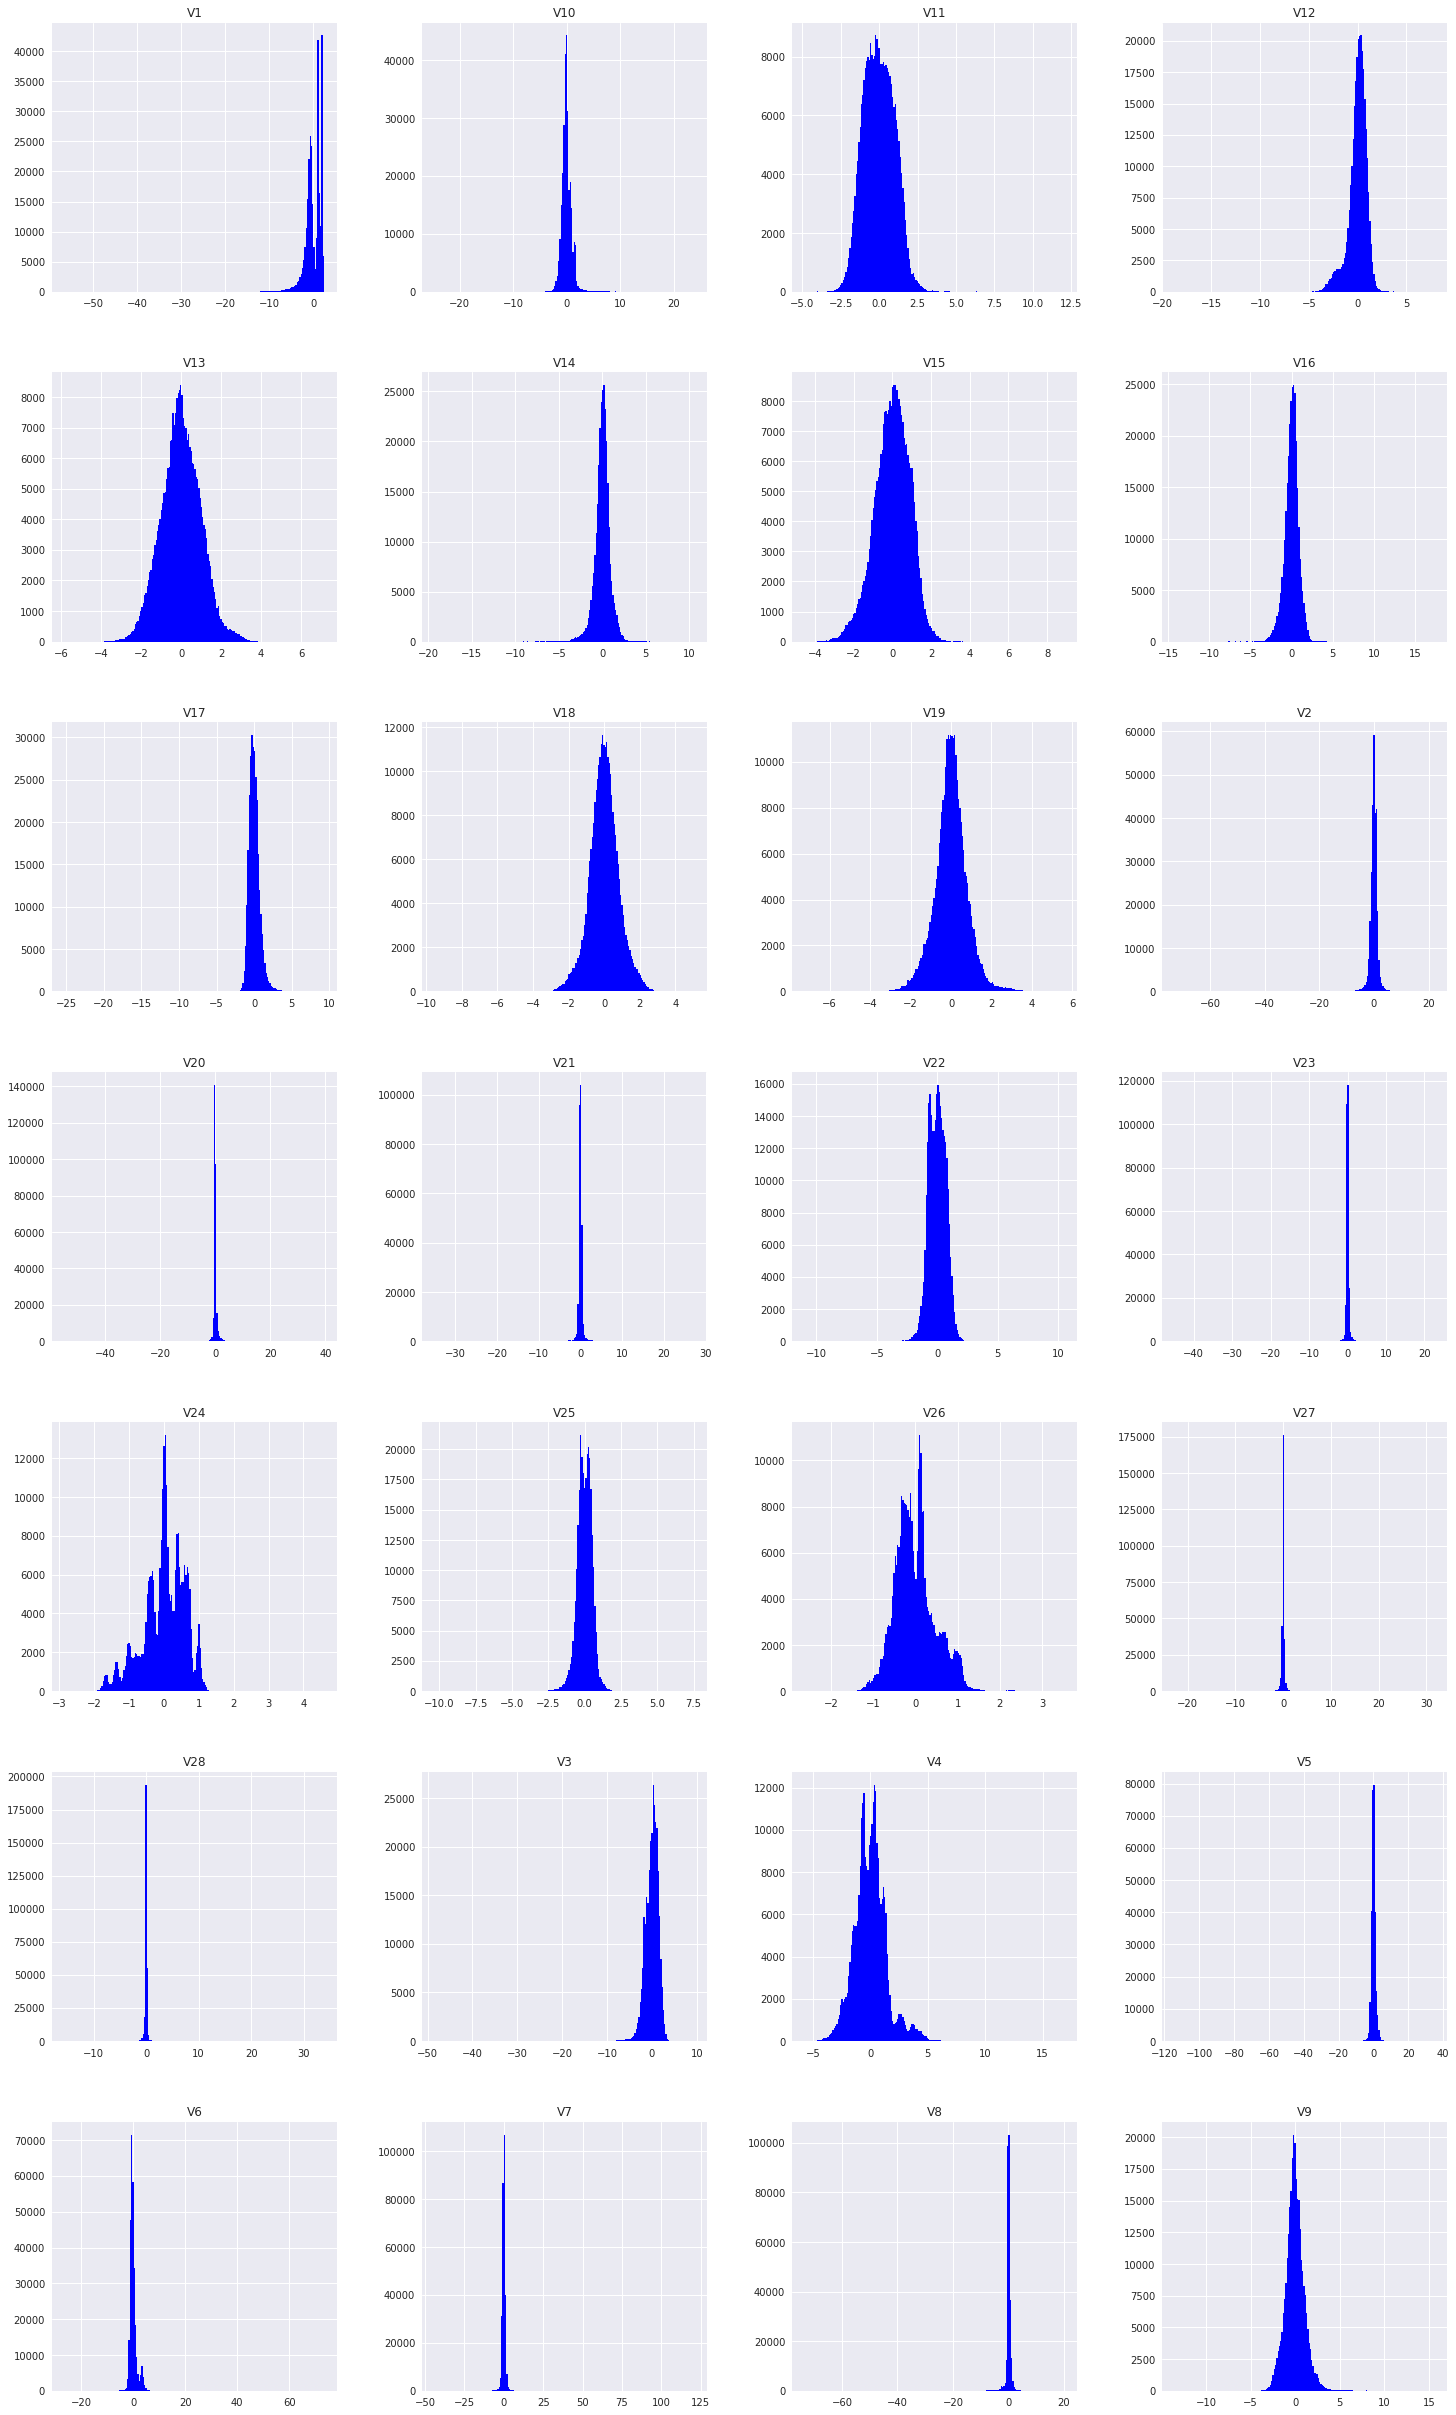

In [11]:
#Check the distribution of all the independent variables
credit_data.drop(['Class','Time', 'Amount'],axis=1).hist(bins=200,color='blue',figsize=(25,50),layout=(8,4))
plt.show()

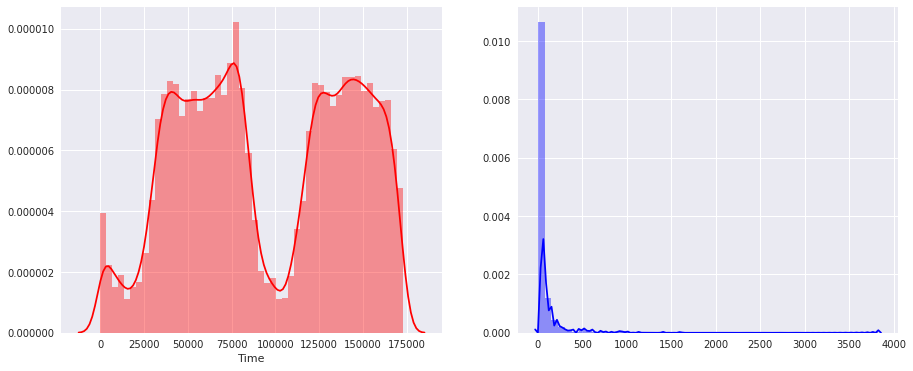

In [12]:
# plotting the graphs of Time and Amount
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.distplot(credit_data['Time'],color='red')
plt.subplot(1,2,2)
sns.distplot(sorted(credit_data['Amount'][0:1000]),color='blue')
plt.show()


In [13]:
# Exploring the amount column in the dataset to get better understanding of the dataset.
print("The lowest transaction amount is: $",credit_data['Amount'].min())
print("The highest transaction amount is: $",credit_data['Amount'].max())
print("The median transaction amount is: $",credit_data['Amount'].median())
print("The average transaction amount is: $",credit_data['Amount'].mean())

print("\nThe lowest transaction amount for fraud transaction is: $",credit_data[credit_data.Class == 1]['Amount'].min())
print("The highest transaction amount for fraud transaction is: $",credit_data[credit_data.Class == 1]['Amount'].max())
print("The median transaction amount for fraud transaction is: $",credit_data[credit_data.Class == 1]['Amount'].median())
print("The average transaction amount for fraud transaction is: $",credit_data[credit_data.Class == 1]['Amount'].mean())

print("\nThe lowest transaction amount for non fraud transaction is: $",credit_data[credit_data.Class == 0]['Amount'].min())
print("The highest transaction amount for non fraud transaction is: $",credit_data[credit_data.Class == 0]['Amount'].max())
print("The median transaction amount for non fraud transaction is: $",credit_data[credit_data.Class == 0]['Amount'].median())
print("The average transaction amount for non fraud transaction is: $",credit_data[credit_data.Class == 0]['Amount'].mean())

The lowest transaction amount is: $ 0.0
The highest transaction amount is: $ 25691.16
The median transaction amount is: $ 22.0
The average transaction amount is: $ 88.34961925087359

The lowest transaction amount for fraud transaction is: $ 0.0
The highest transaction amount for fraud transaction is: $ 2125.87
The median transaction amount for fraud transaction is: $ 9.25
The average transaction amount for fraud transaction is: $ 122.21132113821133

The lowest transaction amount for non fraud transaction is: $ 0.0
The highest transaction amount for non fraud transaction is: $ 25691.16
The median transaction amount for non fraud transaction is: $ 22.0
The average transaction amount for non fraud transaction is: $ 88.29102242225574


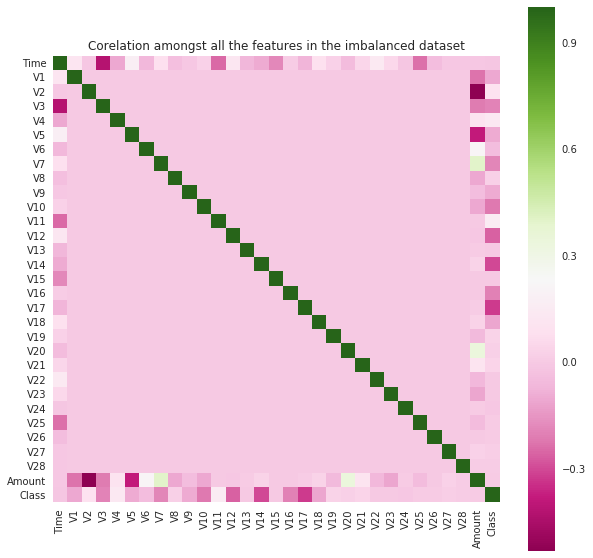

In [13]:
#Get Corelation Matrix between all the features present in the data
cor_matr = credit_data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(cor_matr,square='True',cmap='PiYG')
plt.title('Corelation amongst all the features in the imbalanced dataset')
plt.show()

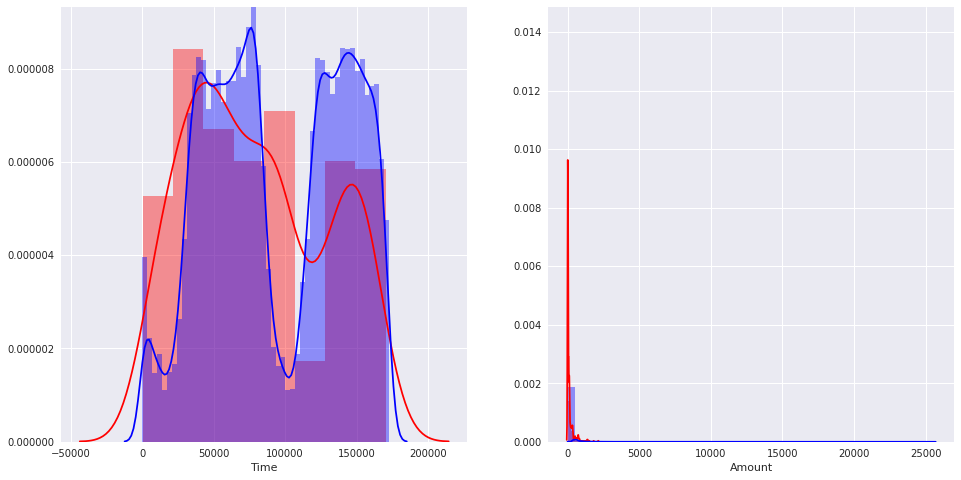

In [14]:
plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
sns.distplot(credit_data[credit_data['Class'] == 1]['Time'][0:] , label = "1", color = 'red')
sns.distplot(credit_data[credit_data['Class'] == 0]['Time'][0:] , label = "0" , color = 'blue' )

plt.subplot(1,2,2)
sns.distplot(credit_data[credit_data['Class'] == 1]['Amount'][0:] , label = "1", color = 'red')
sns.distplot(credit_data[credit_data['Class'] == 0]['Amount'][0:] , label = "0" , color = 'blue' )


plt.show()

In [4]:
# Droping the time column as it doesn't contribute any importance in the dataset
data = credit_data.drop(['Time'], axis = 1) 

In [10]:
# Checking the columns in the dataset after removing the column
data.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [5]:
## Splitting the dataset into test and train
state = 48
from sklearn.model_selection import train_test_split

print("Shape of the original dataset: ", data.shape)

X=data.drop("Class", axis=1)
y=data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=state)

print('\nNumber of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])

Shape of the original dataset:  (284807, 30)

Number of data points in train data: 227845
Number of data points in test data: 56962


## If there is skewness present in the distribution use:
#### Power Transformer package present in the preprocessing library provided by sklearn to make distribution more gaussian

In [6]:
# as the dataset is not skewed, we use the Power Transformer technique to skew the data
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns
power = PowerTransformer(method='yeo-johnson', standardize=True, copy = False)
data1 = power.fit_transform(X_train) 
X_train = pd.DataFrame(data1,columns = X_train.columns)
power = PowerTransformer(method='yeo-johnson', standardize=True, copy = False)
data2 = power.fit_transform(X_test) 
X_test = pd.DataFrame(data2,columns = X_test.columns)

In [9]:
# after transforming the dataset we are checking it

In [11]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.482754,0.781210,1.331547,0.193064,0.036836,-0.619219,0.527944,-0.250002,0.747969,-0.641789,0.673519,-1.883474,2.310144,1.713298,-0.016201,0.085566,0.329951,-0.211326,-0.227332,0.118831,-0.509219,-1.001587,-0.044505,0.471850,-0.411107,0.160549,0.603152,0.369882,-1.315491
1,-0.594240,0.422331,1.233419,-0.320327,-0.163424,-0.599109,0.514255,-0.007681,0.373816,-0.634263,-1.135697,-0.845308,-1.881003,0.019115,-0.623175,-0.238243,-0.071673,-0.554695,-0.082408,-0.108051,-0.290012,-0.666410,-0.237052,0.601385,-0.118726,0.842713,0.677500,0.505252,-0.811631
2,0.476448,-0.241678,0.903535,1.039547,-0.782726,0.117514,-0.534479,0.175049,0.829225,-0.056651,-0.381824,-0.370261,-1.317104,-0.015034,1.069721,-0.120528,0.025530,-0.238036,-1.200019,-0.228033,0.271358,0.786325,-0.076476,0.619195,0.612014,-0.425840,0.158643,0.138360,0.489236
3,-1.612933,-1.524660,1.197017,-0.972322,-0.031599,-0.907313,-0.377484,0.684754,0.927131,-2.150224,-0.273005,1.110578,0.854234,0.024233,2.132539,0.101413,-0.498502,0.579870,-1.398308,1.676508,1.011619,1.178558,0.507252,0.077669,1.303098,-1.512853,0.477331,-0.877412,1.496744
4,-0.873324,0.690864,-0.942417,0.546000,-3.942148,3.220102,5.344935,-1.616089,-0.783934,-0.730587,0.479847,0.541588,1.490890,-0.444745,0.044132,0.441169,-0.876628,0.105960,1.319378,-1.879434,0.183849,-0.336040,-0.610894,-1.783335,-0.289885,-0.708134,2.458541,-1.381374,2.287776


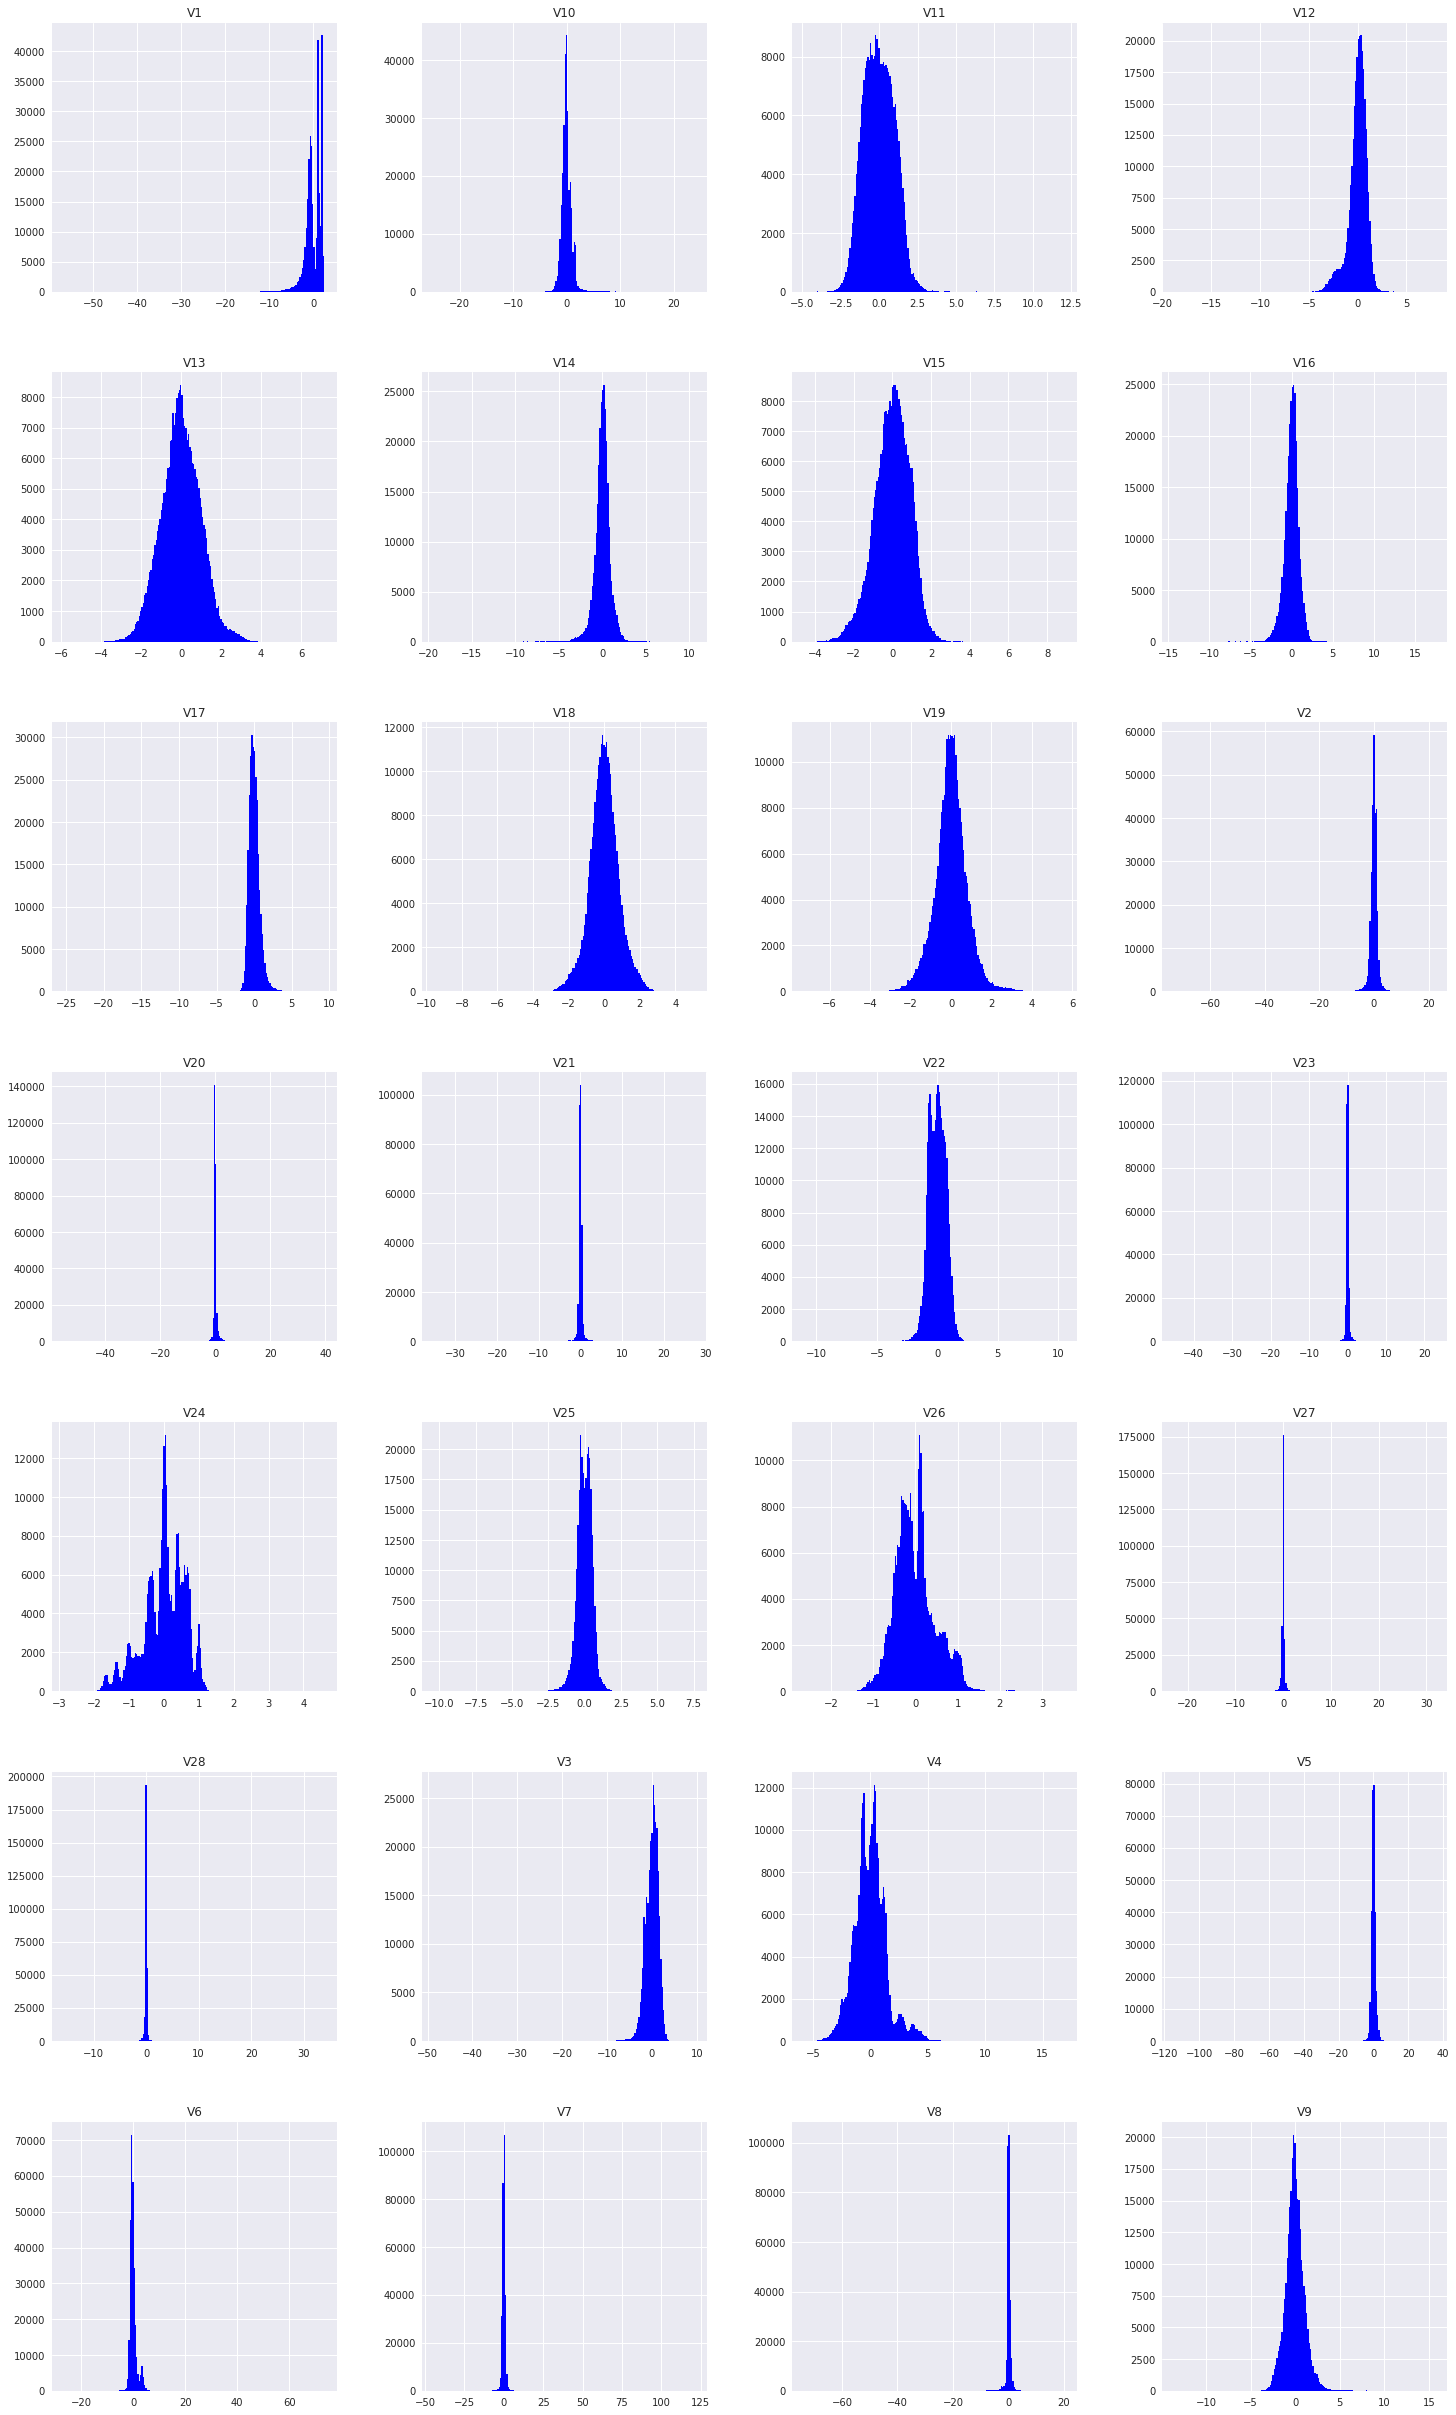

In [18]:
#Check the distribution of all the independent variables after Power Transformation
data.drop(['Class', 'Amount'],axis=1).hist(bins=200,color='blue',figsize=(25,50),layout=(8,4))
plt.show()

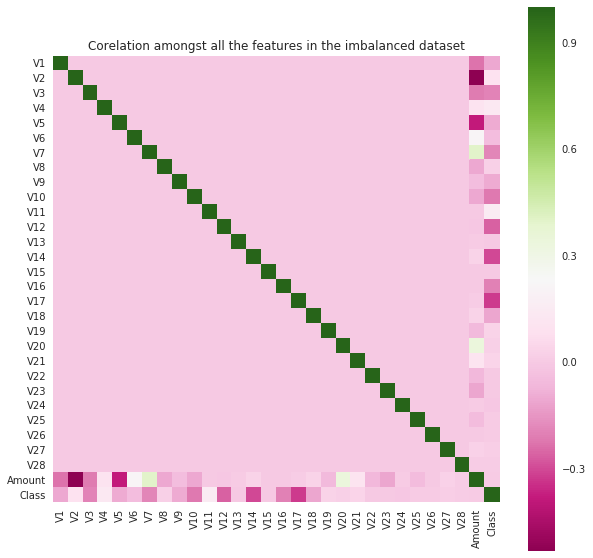

In [19]:
#Get Corelation Matrix between all the features present in the data
cor_matr = data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(cor_matr,square='True',cmap='PiYG')
plt.title('Corelation amongst all the features in the imbalanced dataset')
plt.show()

In [8]:
features=[i for i in data.drop(['Class','Amount'],axis=1).columns]
len(features)

28

<Figure size 1008x576 with 0 Axes>

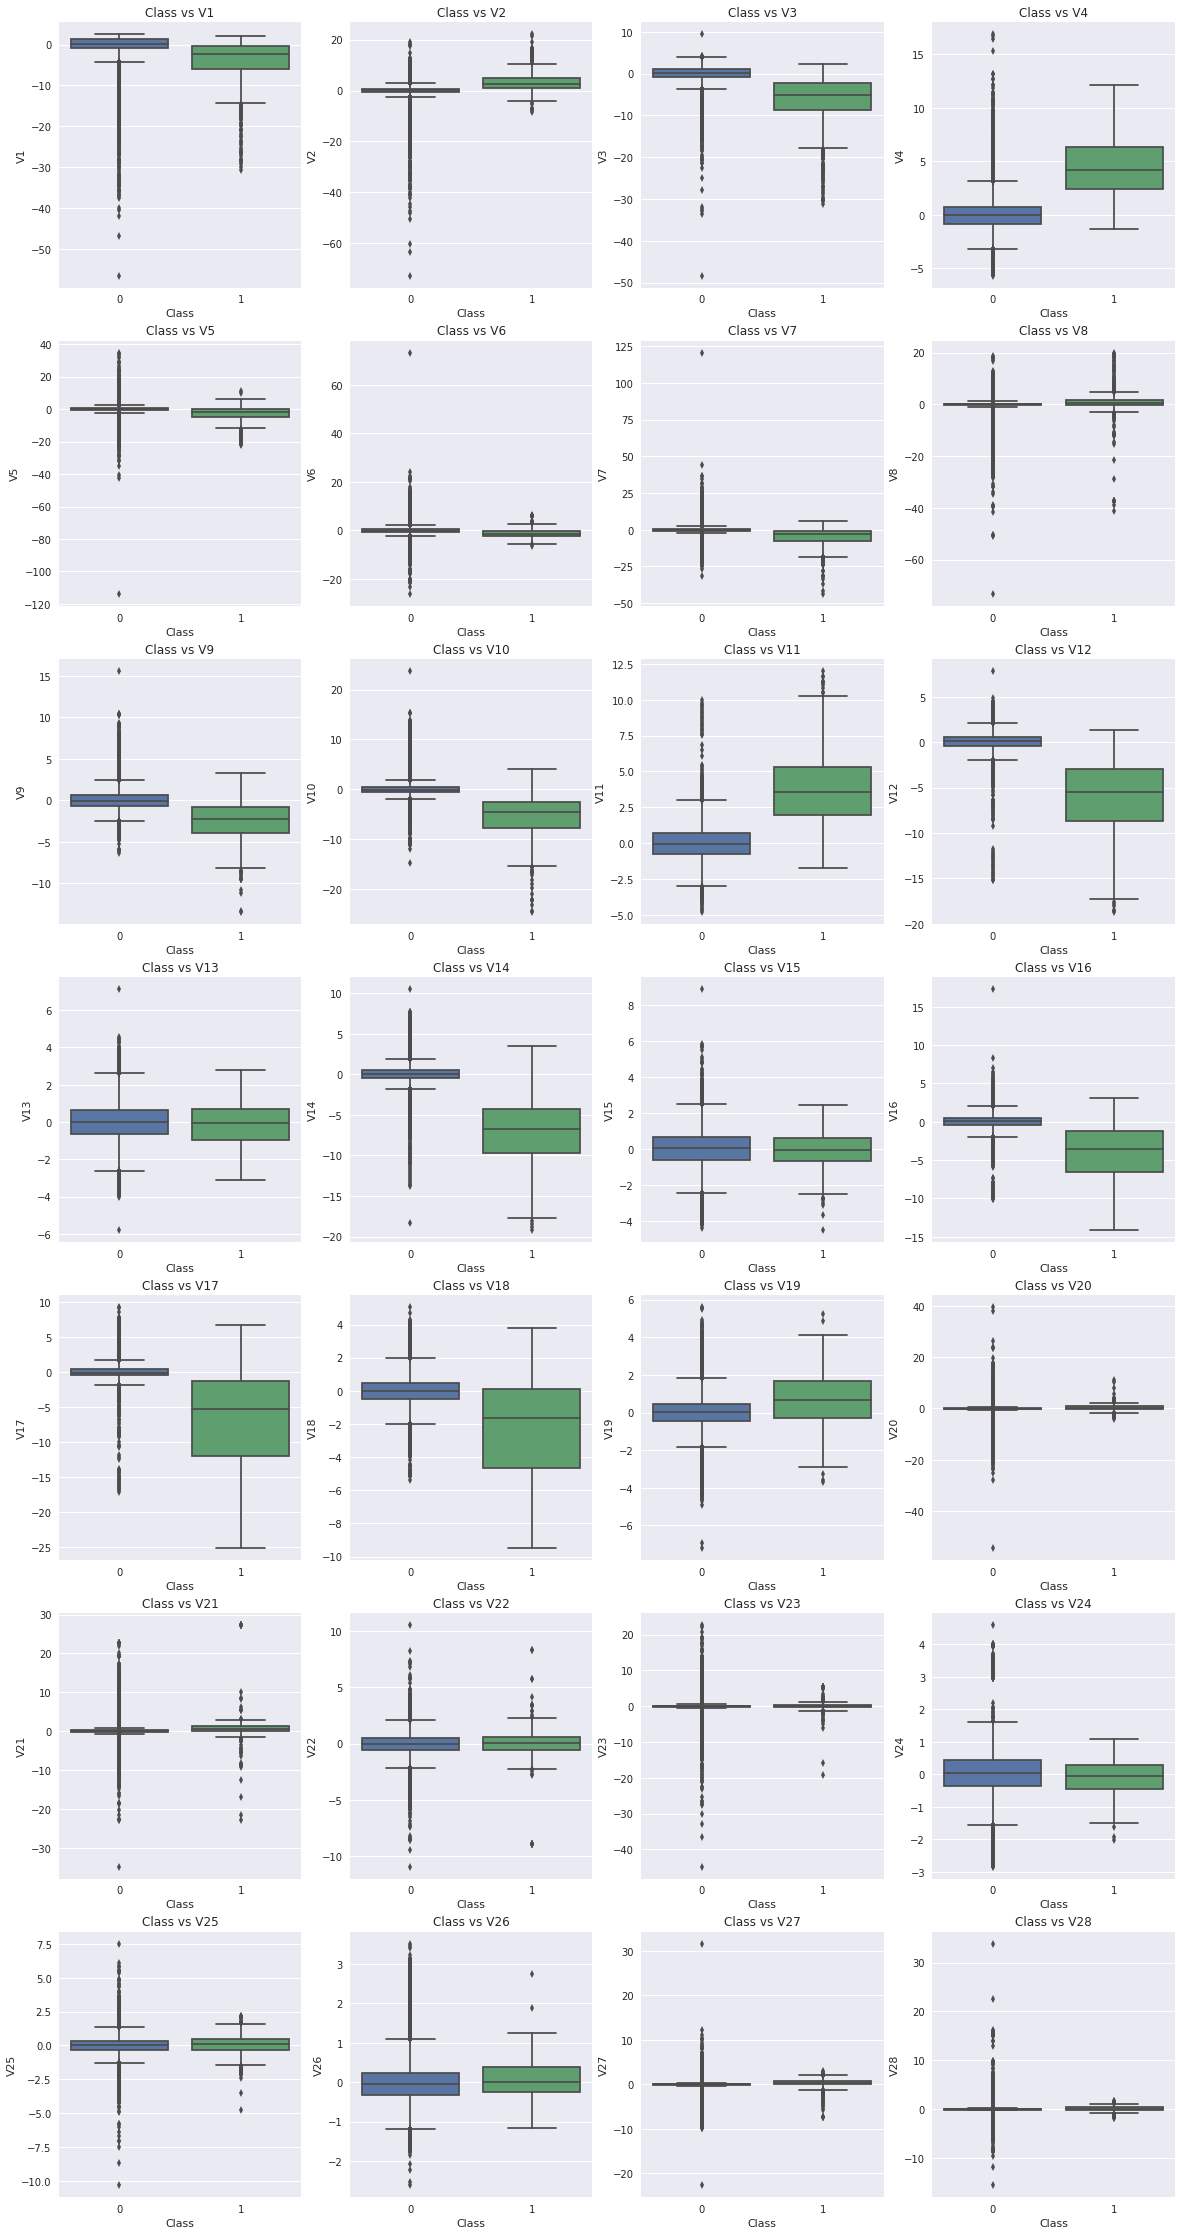

In [22]:
## Plotting the distribution of the various principle component variables
plt.figure(figsize=(14, 8))

fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(20,40))

i_ax=0
for i in range(len(features[0:4])):
    sns.boxplot(x="Class", y=features[i], data=data, ax=axes[i_ax,i])
    axes[i_ax,i].set_title('Class vs {}'.format(features[i]))
    
i_ax=1
for i in range(len(features[4:8])):
    sns.boxplot(x="Class", y=features[4+i], data=data, ax=axes[i_ax,i])
    axes[i_ax,i].set_title('Class vs {}'.format(features[4+i]))
    
i_ax=2
for i in range(len(features[8:12])):
    sns.boxplot(x="Class", y=features[8+i], data=data, ax=axes[i_ax,i])
    axes[i_ax,i].set_title('Class vs {}'.format(features[8+i]))
    
i_ax=3
for i in range(len(features[12:16])):
    sns.boxplot(x="Class", y=features[12+i], data=data, ax=axes[i_ax,i])
    axes[i_ax,i].set_title('Class vs {}'.format(features[12+i]))
    
i_ax=4
for i in range(len(features[16:20])):
    sns.boxplot(x="Class", y=features[16+i], data=data, ax=axes[i_ax,i])
    axes[i_ax,i].set_title('Class vs {}'.format(features[16+i]))
    
i_ax=5
for i in range(len(features[20:24])):
    sns.boxplot(x="Class", y=features[20+i], data=data, ax=axes[i_ax,i])
    axes[i_ax,i].set_title('Class vs {}'.format(features[20+i]))
    
    
i_ax=6
for i in range(len(features[24:28])):
    sns.boxplot(x="Class", y=features[24+i], data=data, ax=axes[i_ax,i])
    axes[i_ax,i].set_title('Class vs {}'.format(features[24+i]))
    
i_ax=7
for i in range(len(features[28:32])):
    sns.boxplot(x="Class", y=features[28+i], data=data, ax=axes[i_ax,i])
    axes[i_ax,i].set_title('Class vs {}'.format(features[28+i]))
    
plt.show()

#### Now we are creating some functions which we will use again and again in the program 

In [7]:
# Creating a function for confusion matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)    
    A =(((C.T)/(C.sum(axis=1))).T)

    B =(C/C.sum(axis=0))

    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [8]:
#This function is used to plot the ROC curve on both train and test.
def plot_roc_curve(classifier, X_train, y_train, X_test, y_test):
    from sklearn.metrics import roc_curve, auc
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    '''TEST DATA ROC CURVE'''
    #Use probability scores to compute the ROC Curve
    class_probabilities = classifier.predict_proba(X_test)
    y_probs = class_probabilities[:,1]
    fpr["Test"], tpr["Test"], threshold = roc_curve(y_test, y_probs)
    roc_auc["Test"] = auc(fpr["Test"], tpr["Test"])
    
    '''TRAIN DATA ROC CURVE'''
    #Use probability scores to compute the ROC Curve
    class_probabilities = classifier.predict_proba(X_train)
    y_probs = class_probabilities[:,1]
    fpr["Train"], tpr["Train"], threshold = roc_curve(y_train, y_probs)
    roc_auc["Train"] = auc(fpr["Train"], tpr["Train"])
    
    plt.figure(figsize=(15,10))
    linewidth = 2
    plt.plot(fpr["Test"], tpr["Test"], color='green', lw=linewidth, label='ROC curve Test Data (area = %0.2f)' % roc_auc["Test"])
    plt.plot(fpr["Train"], tpr["Train"], color='red', lw=linewidth, label='ROC curve Train Data (area = %0.2f)' % roc_auc["Train"])
    plt.plot([0, 1], [0, 1], color='navy', lw=linewidth, linestyle='--', label='Baseline ROC curve (area = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [9]:
## this function is used to display the model report, to get the best F1 score, Recall, Accuracy, ROC-AUC score
def model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels):
    
    results = dict()
    model = rsearch_cv.best_estimator_
    
    #Time at which model starts training 
    train_start_time = dt.now()
    print('Training the model...')
    model.fit(X_train, y_train)
    print('Training completed... \n \n')
    train_end_time = dt.now()
    results['Training_Time'] =  train_end_time - train_start_time
    print('Training Time (HH:MM:SS.ms) -- {}\n\n'.format(results['Training_Time']))
    
    
    #Predict the test data
    print('Predicting test data...')
    test_start_time = dt.now()
    y_pred = model.predict(X_test)
    test_end_time = dt.now()
    print('Predicting test data completed... \n \n')
    results['Testing_Time'] = test_end_time - test_start_time
    print('Testing Time(HH:MM:SS:ms) -- {}\n\n'.format(results['Testing_Time']))
    results['Predicted'] = y_pred
   

    #Compute the F1 score 
    f1_score = metrics.f1_score(y_true=y_test, y_pred=y_pred, average='micro') #F1 = 2 * (precision * recall) / (precision + recall)
    
    #Store F1 Score in results
    results['F1_Score'] = f1_score
    print('---------------------')
    print('|      F1 Score      |')
    print('---------------------')
    print('\n    {}\n\n'.format(f1_score)) 
    #Calculate overall accuracy of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
        
    #Store the accuracy in results
    results['Accuracy'] = accuracy
    print('---------------------')
    print('|      Accuracy      |')
    print('---------------------')
    print('\n    {}\n\n'.format(accuracy))
    
    #Calculate overall recall_score of the model
    recall = metrics.recall_score(y_true=y_test, y_pred=y_pred)
        
    #Store the accuracy in results
    results['Recall'] = recall
    print('---------------------')
    print('|      Recall        |')
    print('---------------------')
    print('\n    {}\n\n'.format(recall))
    
    #Calculate overall roc-auc of the model
    #Calibrate the model
    sig_clf = CalibratedClassifierCV(model, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    class_probabilities = sig_clf.predict_proba(X_test)
    y_probs = class_probabilities[:,1]
    roc_auc = metrics.roc_auc_score(y_true=y_test, y_score=y_probs)
        
    #Store the ROC-AUC in results
    results['ROC-AUC'] = roc_auc
    print('---------------------')
    print('|      ROC AUC       |')
    print('---------------------')
    print('\n    {}\n\n'.format(roc_auc))   
                   
    #Display the classification report having individual class recalls and precision values.
    print('-------------------------')
    print('| Classifiction Report  |')
    print('-------------------------')
    classification_report = metrics.classification_report(y_test, y_pred)
    
    #Store report in results
    results['Classification_Report'] = classification_report
    print(classification_report)
    
    #Add the trained  model to the results
    results['Model'] = model
    
    #Plot the confusion matrix curve
    plot_confusion_matrix(y_test, y_pred)
    
    return results, model

In [10]:
# to print the best grid search parameters
def print_grid_search_attributes(model):
    #Estimator that gave highest score among all the estimators formed in GridSearch
    print('--------------------------')
    print('|      Best Estimator     |')
    print('--------------------------')
    print('\n\t{}\n'.format(model.best_estimator_))

    #Parameters that gave best results while performing grid search
    print('--------------------------')
    print('|     Best parameters     |')
    print('--------------------------')
    print('\tParameters of best estimator : \n\n\t{}\n'.format(model.best_params_))

    #Number of cross validation splits
    print('---------------------------------')
    print('|   No of CrossValidation sets   |')
    print('--------------------------------')
    print('\n\tTotal numbre of cross validation sets: {}\n'.format(model.n_splits_))

    #Average cross validated score of the best estimator, from the Grid Search 
    print('--------------------------')
    print('|        Best Score       |')
    print('--------------------------')
    print('\n\tAverage Cross Validate scores of best estimator : \n\n\t{}\n'.format(model.best_score_))

### Creating model on unbalanced dataset

#### Logistic Regression Classifier

In [11]:
# importing some libraries required for running the regression 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from datetime import datetime as dt

In [90]:
## building the regression model, we are using the grid search method to get the best combination of values, C values used for cross validation
st=dt.now()

tuned_parameters = {'C': np.logspace(-4,3,50),
                     'penalty': ['l1','l2'] } 

model = LogisticRegression(n_jobs=-1, random_state=state)
rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=tuned_parameters, 
                                cv=3, scoring='roc_auc',
                                verbose=5,
                                n_jobs=-1,
                                random_state=state)
rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   15.7s finished


Time taken to complete random search:  0:00:21.347730


In [91]:
# printing the value for best estimators, Best parameters, No of CrossValidation sets and Best Score
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	LogisticRegression(C=1.389495494373136, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=48, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'penalty': 'l2', 'C': 1.389495494373136}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 3

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.9778294071524698



Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:00:05.419303


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:00:00.003866


---------------------
|      F1 Score      |
---------------------

    0.9991573329588147


---------------------
|      Accuracy      |
---------------------

    0.9991573329588147


---------------------
|      Recall        |
---------------------

    0.6020408163265306


---------------------
|      ROC AUC       |
---------------------

    0.9662520959424852


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.60      0.71        98

    accuracy                           1.00     56962
   macro avg       0.93      0.80      0.86     56962
weighted avg       1.00      1.00      1.00     56962



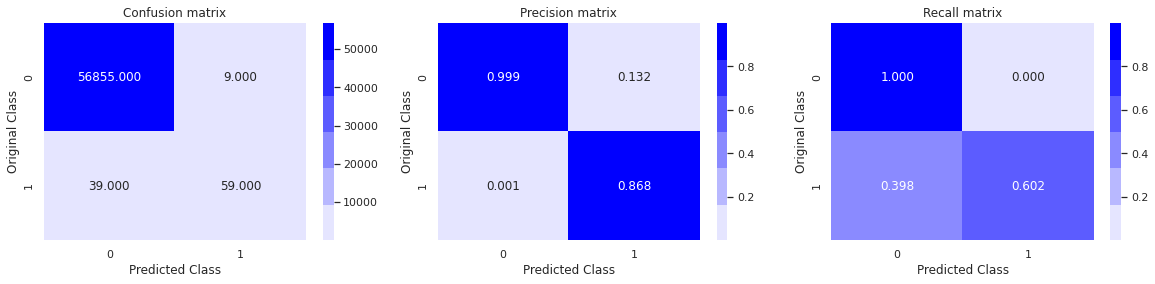

In [92]:
# printing the best value for F1 score, accuracy, ROC-AUC, Recall and a confuion matrix plot
log_reg_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels=y_train.values)

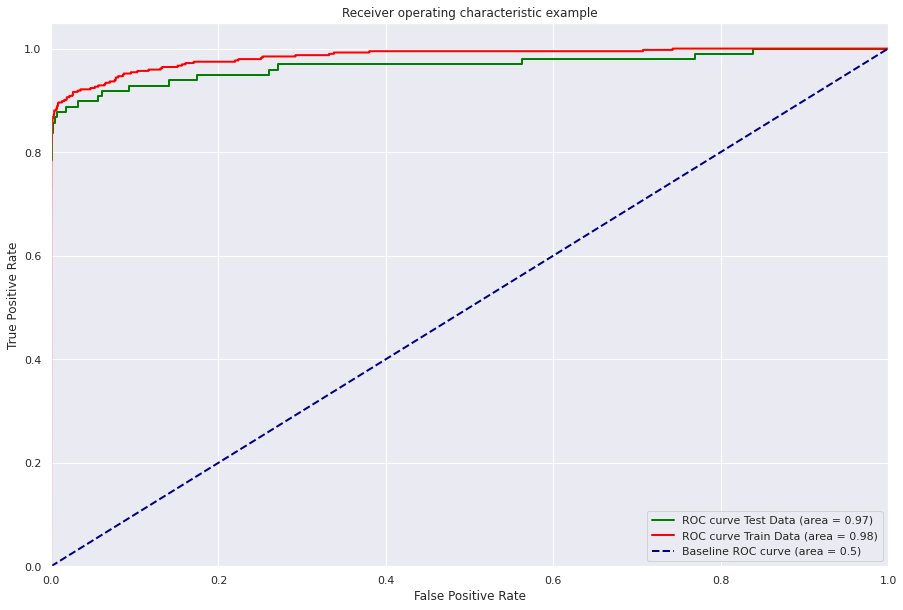

In [93]:
#Calibrate the model
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

In [ ]:
## KNN Classifier

In [14]:
# building the KNN classifier model
from sklearn.neighbors import KNeighborsClassifier

st=dt.now()

tuned_parameters = {'n_neighbors': [9,11],
                    'weights': ['uniform','distance'] }

model = KNeighborsClassifier(n_jobs=-1, p=2, metric='minkowski')

rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=tuned_parameters, 
                                cv=3, scoring='roc_auc',
                                verbose=5,
                                n_jobs=-1,
                                random_state=state)

rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  12 | elapsed: 33.7min remaining: 16.8min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 50.7min finished


Time taken to complete random search:  0:50:44.212510


In [15]:
# printing the value for best estimators, Best parameters, No of CrossValidation sets and Best Score
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	KNeighborsClassifier(n_jobs=-1, n_neighbors=9, weights='distance')

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'weights': 'distance', 'n_neighbors': 9}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 3

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.9313108533035644



Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:00:01.563107


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:03:50.788946


---------------------
|      F1 Score      |
---------------------

    0.9995259997893332


---------------------
|      Accuracy      |
---------------------

    0.9995259997893332


---------------------
|      Recall        |
---------------------

    0.7653061224489796


---------------------
|      ROC AUC       |
---------------------

    0.928339582878734


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.77      0.85        98

    accuracy                           1.00     56962
   macro avg       0.97      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962



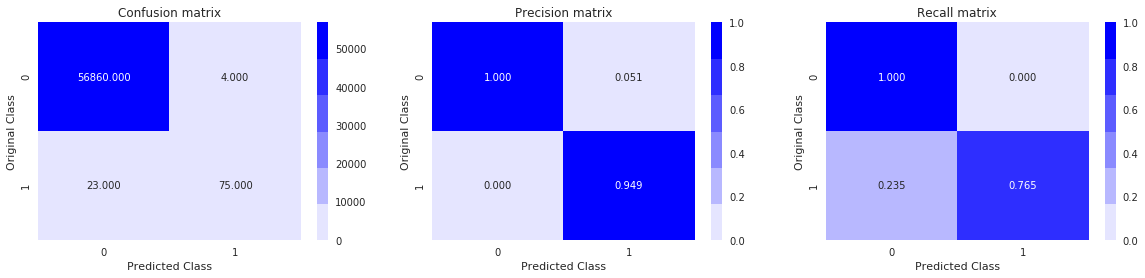

In [16]:
# printing the best value for F1 score, accuracy, ROC-AUC, Recall and a confuion matrix plot
knn_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels=y_train)

In [ ]:
#Calibrate the model
from sklearn.calibration import CalibratedClassifierCV
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

#### Decision Trees Classifier

In [19]:
## Building an Decision Tree model
from sklearn.tree import DecisionTreeClassifier
st=dt.now()

tuned_parameters = {'max_depth': np.arange(1,10,1),
                    'criterion': ['gini','entropy'],
                    'min_samples_split': np.arange(0.1,1.0,0.1),
                    'min_samples_leaf' : np.arange(1,10,1),
                    'min_weight_fraction_leaf' : [0.0,0.1,0.2,0.3,0.4],
                    'max_features': ['auto','sqrt','log2']} 

model = DecisionTreeClassifier(random_state=state)
rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=tuned_parameters, 
                                cv=5, scoring='roc_auc', 
                                n_jobs=-1,
                                verbose=5,
                                random_state=state)
rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.5s finished


Time taken to complete random search:  0:00:16.051692


In [20]:
# printing the value for best estimators, Best parameters, No of CrossValidation sets and Best Score
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=0.6,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=48, splitter='best')

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'min_weight_fraction_leaf': 0.0, 'min_samples_split': 0.6, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 6, 'criterion': 'entropy'}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 5

--------------------------
|        Best Score       |
--------------------

Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:00:01.414836


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:00:00.007638


---------------------
|      F1 Score      |
---------------------

    0.9981742214107651


---------------------
|      Accuracy      |
---------------------

    0.9981742214107651


---------------------
|      Recall        |
---------------------

    0.47959183673469385


---------------------
|      ROC AUC       |
---------------------

    0.9493064547850654


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.47      0.48      0.47        98

    accuracy                           1.00     56962
   macro avg       0.73      0.74      0.74     56962
weighted avg       1.00      1.00      1.00     56962



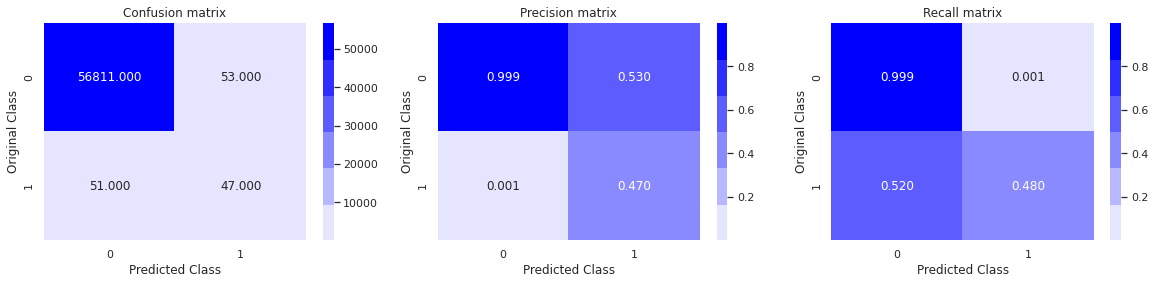

In [21]:
# printing the best value for F1 score, accuracy, ROC-AUC, Recall and a confuion matrix plot
dt_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels=y_train)

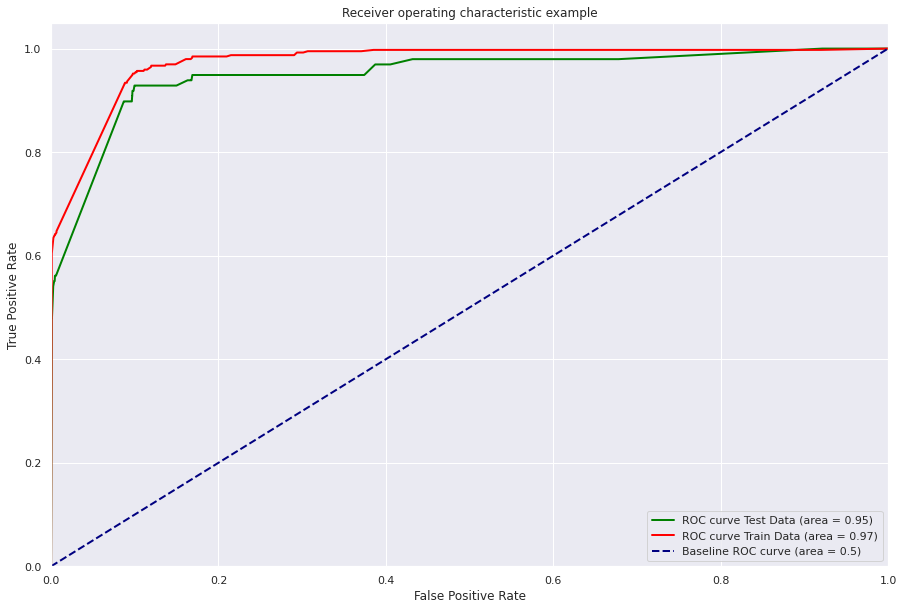

In [22]:
#Calibrate the model
from sklearn.calibration import CalibratedClassifierCV
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

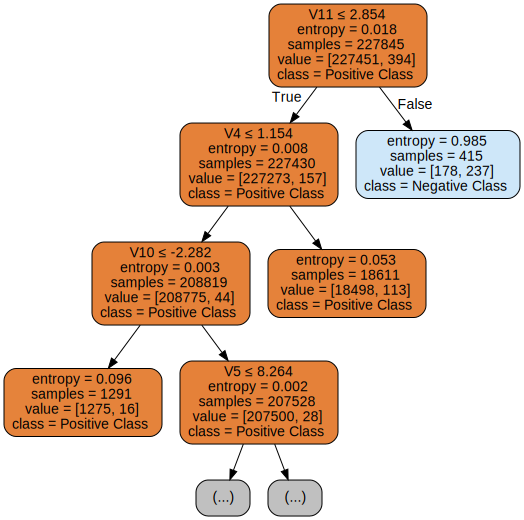

In [23]:
# Visualizing the decision Tree
def visualize_tree(trained_clf, f_names, filename):
    from sklearn import tree
    import graphviz
    dot_data = tree.export_graphviz(decision_tree=trained_clf, out_file=None, max_depth=3, filled=True, rounded=True, special_characters=True, impurity=True, feature_names=f_names, class_names=['Positive Class','Negative Class'])  
    graph = graphviz.Source(dot_data)  
    graph.render(filename, format='png') 
    return graph

#Call the function above and pass a filename onto it.
f_names=[i for i in X.columns]

graph=visualize_tree(trained_model, f_names, 'Credit_Card_Tree.png')
graph

#### Random Forest Classifier

In [24]:
# Building the Random Forest model
from sklearn.ensemble import RandomForestClassifier

st=dt.now()
tuned_parameters = {'max_depth':[6,7,8,9],
                    'criterion':['gini','entropy'],
                    'min_samples_split':[2,3,5], 
                    'max_features':['auto','sqrt'],
                    'min_samples_leaf':[10, 25, 50, 75],
                    'n_estimators':[5,30,50,80,100],
                    'max_leaf_nodes':[50, 100, 500]}

model = RandomForestClassifier(random_state=state)
rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=tuned_parameters, 
                                cv=5, scoring='roc_auc', 
                                n_jobs=-1,
                                verbose=5,
                                random_state=state)
rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 20.0min finished


Time taken to complete random search:  0:20:34.212415


In [25]:
## printing the value for best estimators, Best parameters, No of CrossValidation sets and Best Score 
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=100, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=48, verbose=0,
                       warm_start=False)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'n_estimators': 30, 'min_samples_split': 3, 'min_samples_leaf': 50, 'max_leaf_nodes': 100, 'max_features': 'auto', 'max_depth': 8, 'criterion': 'entropy'}

---------------------------------
|   No of CrossValidation sets   |
----------------------------

Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:00:35.683223


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:00:00.103840


---------------------
|      F1 Score      |
---------------------

    0.9992802219023208


---------------------
|      Accuracy      |
---------------------

    0.9992802219023208


---------------------
|      Recall        |
---------------------

    0.6632653061224489


---------------------
|      ROC AUC       |
---------------------

    0.9689258581879573


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.66      0.76        98

    accuracy                           1.00     56962
   macro avg       0.94      0.83      0.88     56962
weighted avg       1.00      1.00      1.00     56962



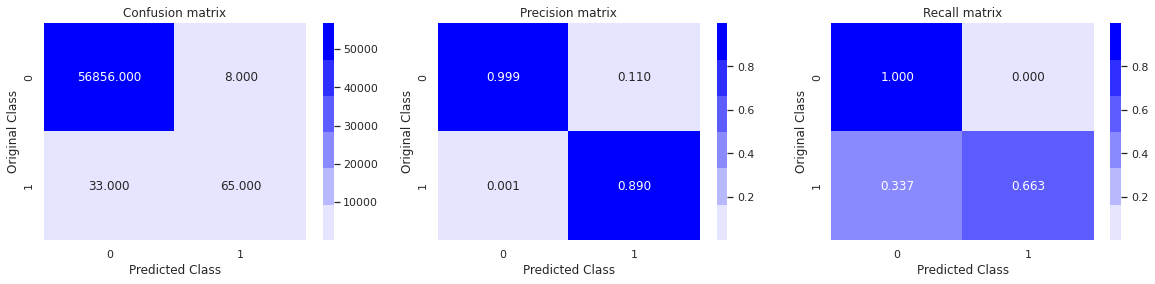

In [26]:
# printing the best value for F1 score, accuracy, ROC-AUC, Recall and a confuion matrix plot
rf_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels=y_train)

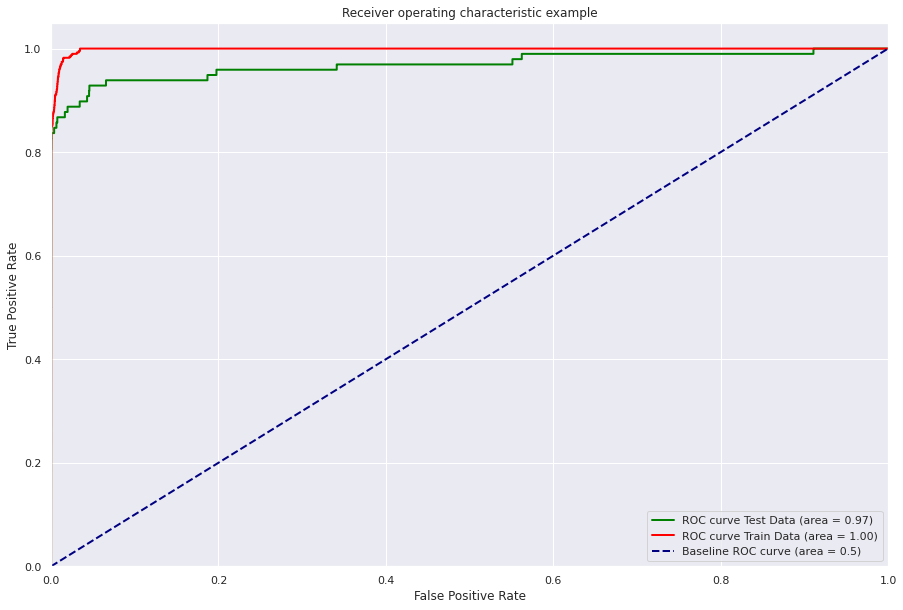

In [27]:
#Calibrate the model
from sklearn.calibration import CalibratedClassifierCV
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

No Sampling:
1. Logistic Regression --
a. Accuracy: 99.9
b. Recall: 60.2
c. F1 Score: 99.9
d. ROC AUC: 96.6
    
2. Decision Tree --
a. Accuracy: 99.8
b. Recall: 47.95
c. F1 Score: 99.8
d. ROC AUC: 94.93
    
3. Random Forest --
a. Accuracy: 99.9
b. Recall: 66.3
c. F1 Score: 99.9
d. ROC AUC: 96.8
    
4. KNN --
a. Accuracy: 99.9
b. Recall: 76.5
c. F1 Score: 99.9
d. ROC AUC: 92.8
    

## Under-sample the dataset to balance the classes

In [22]:
data_fraud=data[data['Class']==1]
data_valid=data[data['Class']==0].sample(data_fraud.shape[0],random_state=state)
data_under=pd.concat([data_fraud,data_valid])

#We will shuffle our dataset after concatenating
data_under = data_under.sample(frac=1).reset_index(drop=True)
data_under.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.184557,-1.201865,1.645981,-0.121040,-1.788183,0.741082,-1.568678,0.336886,0.738871,0.118569,...,0.149068,0.846430,-0.107808,0.185744,0.449095,-0.022680,0.105524,0.031471,42.30,0
1,-0.600257,1.344225,-0.956503,-0.801516,0.711592,-0.447936,0.593740,0.365375,0.299440,-0.017374,...,-0.395941,-0.928162,0.099991,0.198920,-0.363236,0.100102,0.130672,-0.091315,8.95,0
2,2.106779,0.106634,-2.310409,-0.065901,1.039209,-0.737634,0.561478,-0.418618,1.285569,-0.187648,...,0.016256,0.321626,-0.085260,0.185729,0.461458,0.180145,-0.126991,-0.091217,21.03,0
3,-2.129137,2.771143,-2.674043,-0.474451,0.006576,-0.384623,-0.795160,-0.358250,-0.051051,-0.701137,...,1.870793,0.301576,0.104879,-0.047791,-0.073170,-0.172615,-0.489617,-0.231619,15.70,0
4,2.180149,0.218732,-2.637726,0.348776,1.063546,-1.249197,0.942021,-0.547652,-0.087823,0.280152,...,0.234502,0.825237,-0.176957,0.563779,0.730183,0.707494,-0.131066,-0.090428,0.00,0


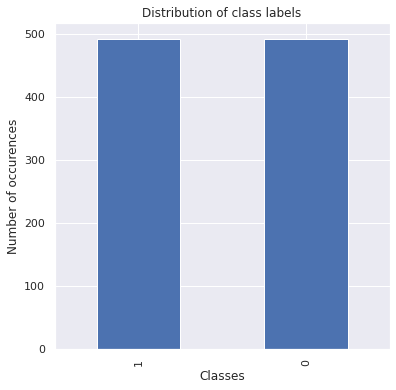

In [19]:
#Check the class distribution in the given data
data_under['Class'].value_counts().plot(figsize=(6,6),kind='bar')
plt.title("Distribution of class labels")
plt.xlabel("Classes")
plt.ylabel("Number of occurences")
plt.show()

In [23]:
#Get percentage fradulent information in the balanced dataset
not_fraud=data_under[data_under['Class']==0].shape[0]
fraud=data_under[data_under['Class']==1].shape[0]
total=fraud+not_fraud

print("Percentage of Fradulent transaction: {}".format(np.round(100*fraud/total,4)))
print("Percentage of Non Fradulent transaction: {}".format(np.round(100*not_fraud/total,4)))

Percentage of Fradulent transaction: 50.0
Percentage of Non Fradulent transaction: 50.0


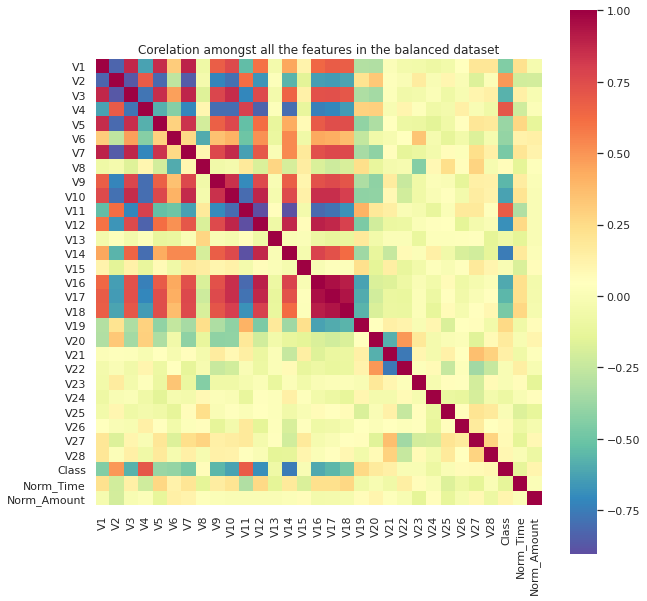

In [21]:
#Get Corelation Matrix between all the features present in the under sampled data
cor_matr = data_under.corr()
plt.figure(figsize=(10,10))
sns.heatmap(cor_matr,square='True',cmap='Spectral_r')
plt.title('Corelation amongst all the features in the balanced dataset')
plt.show()

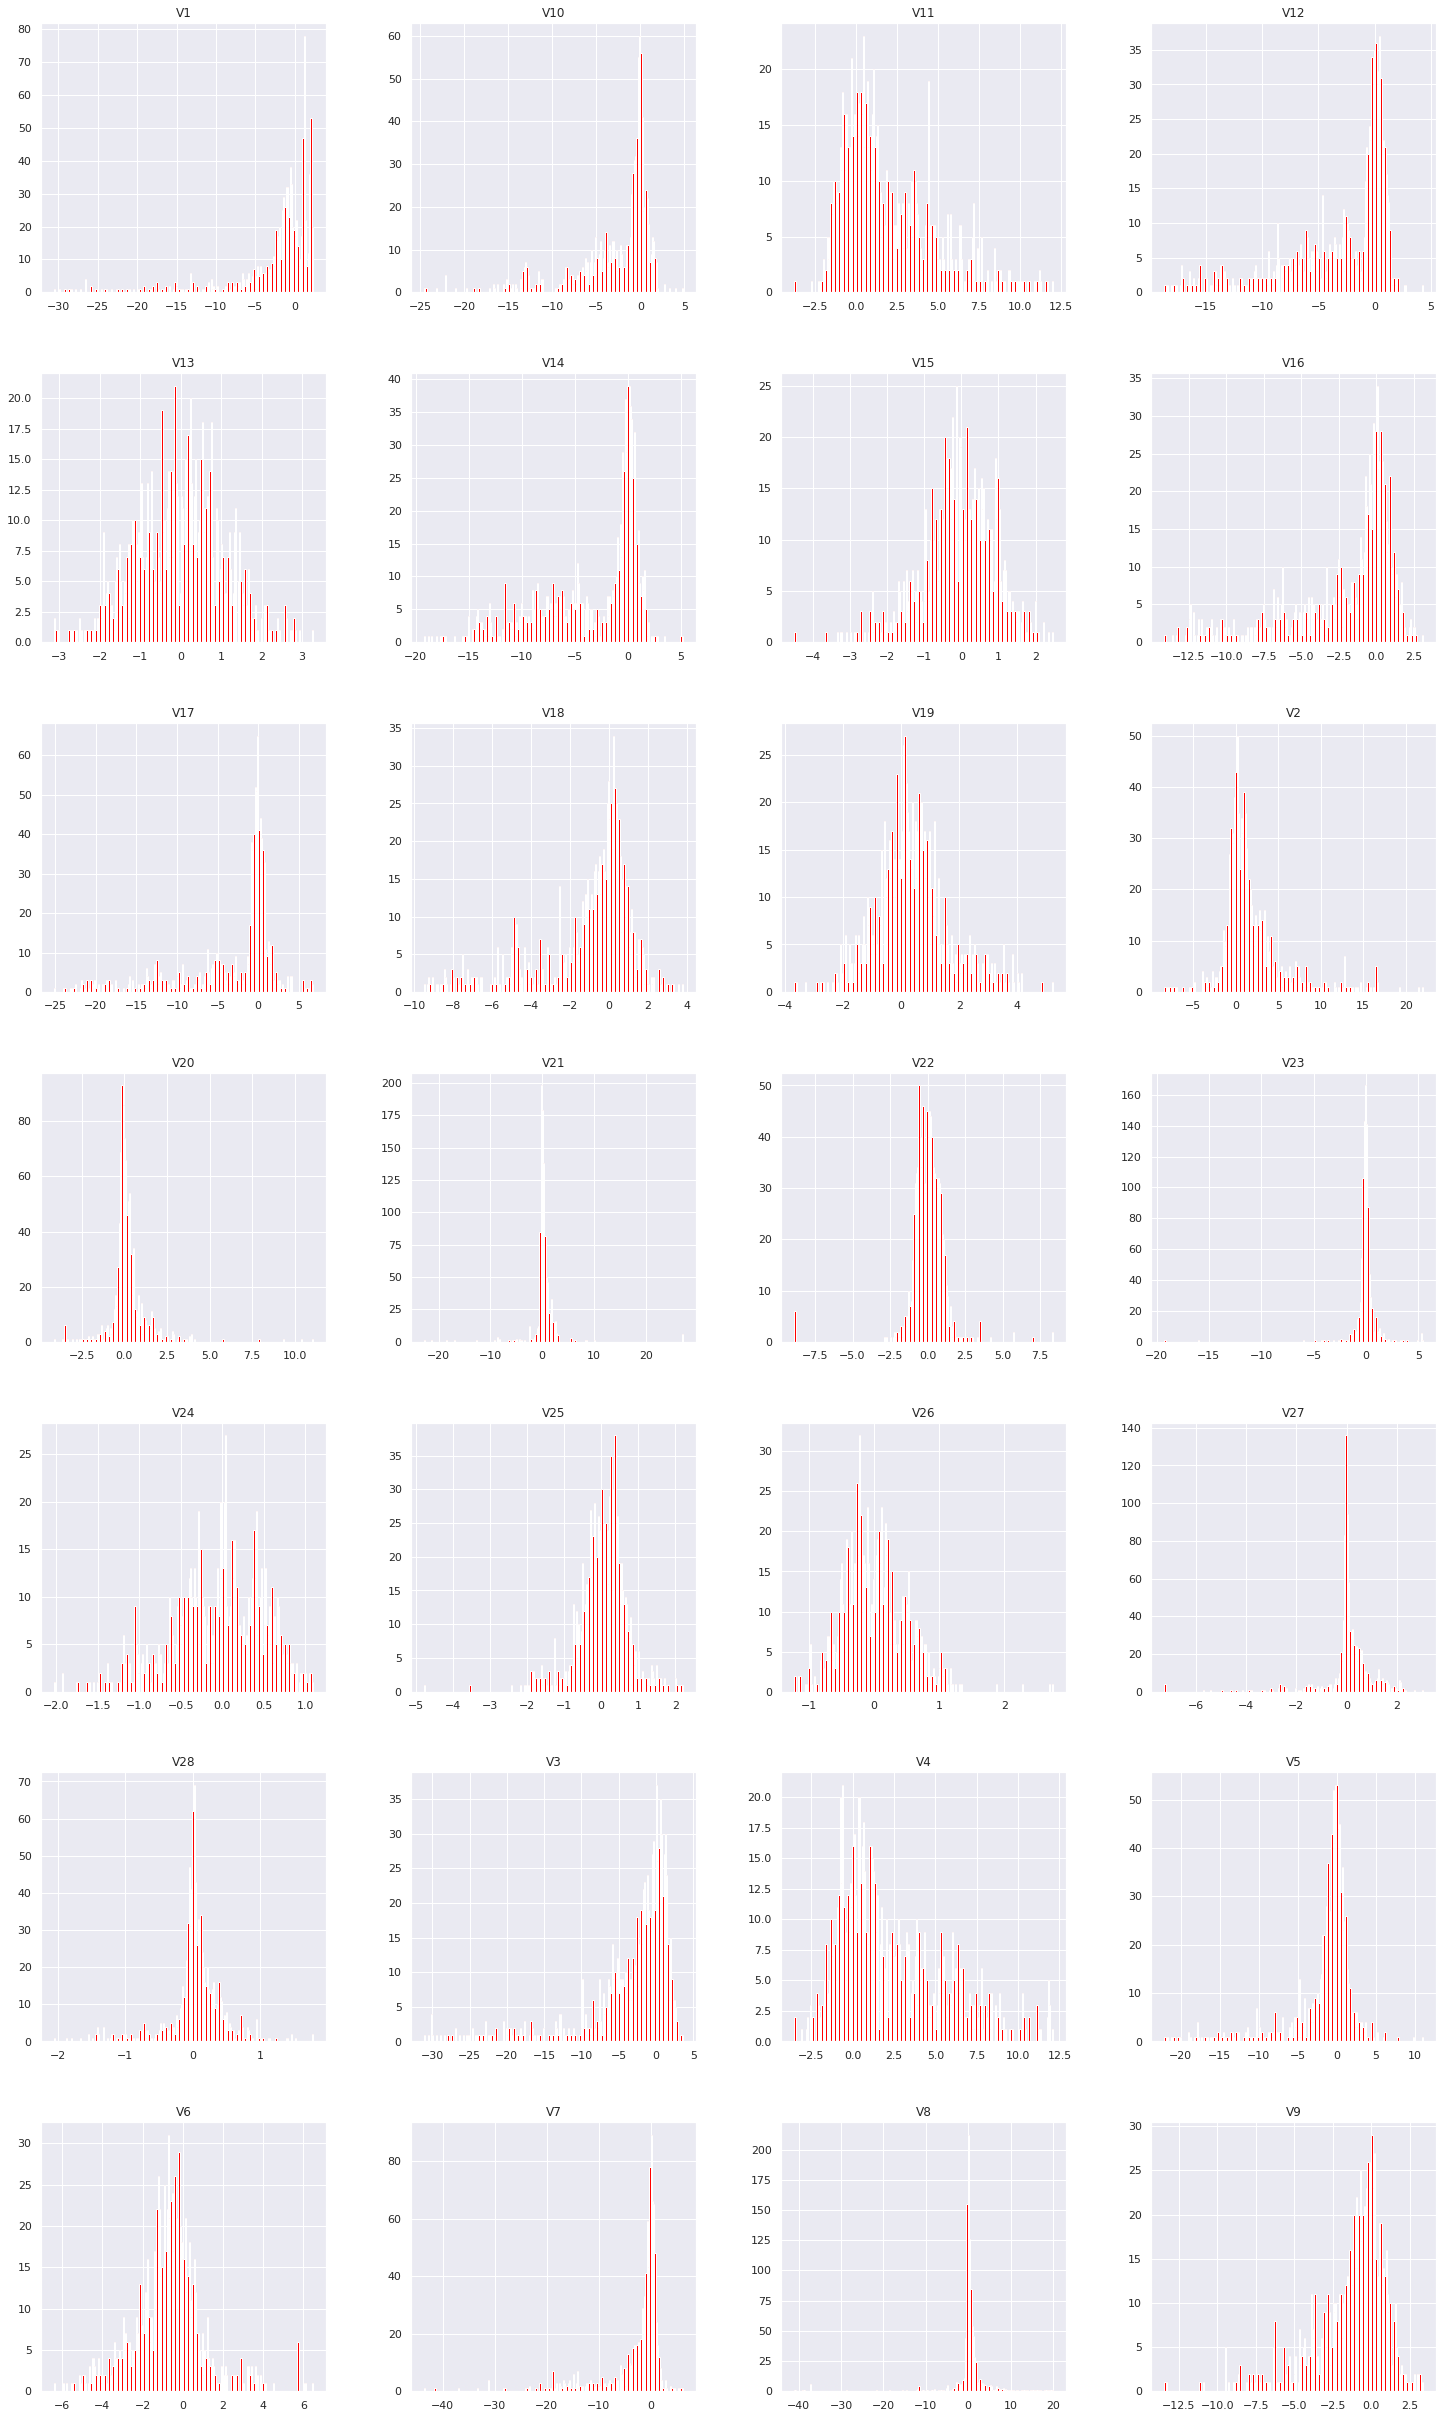

In [22]:
#Check the distribution of all the independent variables for the under sampled dataset
data_under.drop(['Class','Amount'],axis=1).hist(bins=200,color='red',figsize=(25,50),layout=(8,4))
plt.show()

In [24]:
## Splitting the dataset into test and train and checking the number of test and train datapoints
from sklearn.model_selection import train_test_split

X=data_under.drop("Class", axis=1)
y=data_under['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=state)

print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])

Number of data points in train data: 787
Number of data points in test data: 197


In [25]:
# as the dataset is not skewed, we use the Power Transformer technique to skew the data
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns
power = PowerTransformer(method='yeo-johnson', standardize=True, copy = False)
data1 = power.fit_transform(X_train) 
X_train = pd.DataFrame(data1,columns = X_train.columns)
power = PowerTransformer(method='yeo-johnson', standardize=True, copy = False)
data2 = power.fit_transform(X_test) 
X_test = pd.DataFrame(data2,columns = X_test.columns)

#### Logistic Regression Classifier

In [36]:
# Creating a logistic Regression Model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from datetime import datetime as dt

st=dt.now()

tuned_parameters = {'C': np.logspace(-4,3,50),
                     'penalty': ['l1','l2'] } #C values used for cross validation

model = LogisticRegression(n_jobs=-1, random_state=state)
rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=tuned_parameters, 
                                cv=3, scoring='roc_auc',
                                verbose=5,
                                n_jobs=-1,
                                random_state=state)
rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.9s


Time taken to complete random search:  0:00:02.663070


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.6s finished


In [37]:
# printing the value for best estimators, Best parameters, No of CrossValidation sets and Best Score
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	LogisticRegression(C=0.0005179474679231213, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=48, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'penalty': 'l2', 'C': 0.0005179474679231213}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 3

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.9778761921410952



Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:00:00.015857


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:00:00.000777


---------------------
|      F1 Score      |
---------------------

    0.9238578680203046


---------------------
|      Accuracy      |
---------------------

    0.9238578680203046


---------------------
|      Recall        |
---------------------

    0.8469387755102041


---------------------
|      ROC AUC       |
---------------------

    0.9902082044939188


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        99
           1       1.00      0.85      0.92        98

    accuracy                           0.92       197
   macro avg       0.93      0.92      0.92       197
weighted avg       0.93      0.92      0.92       197



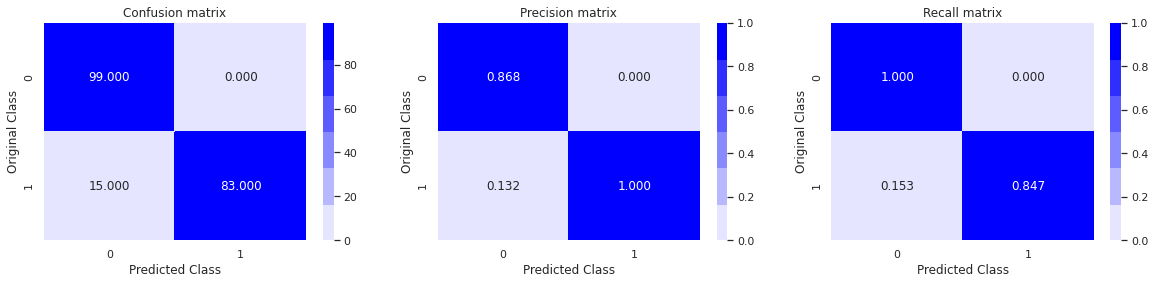

In [38]:
# printing the best value for F1 score, accuracy, ROC-AUC, Recall and a confuion matrix plot
log_reg_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels=y_train.values)

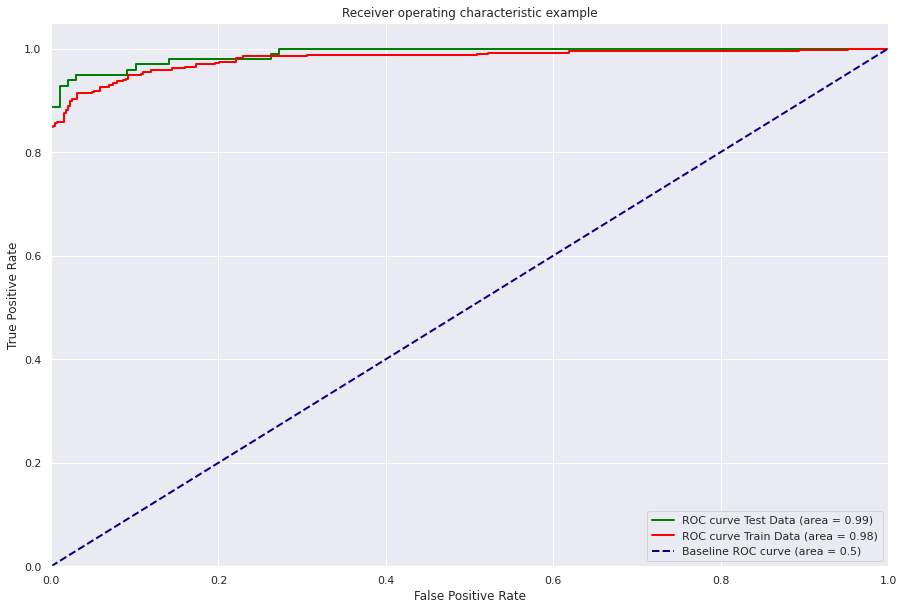

In [39]:
#Calibrate the model
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)


#### KNN Classifier model

In [61]:
## Building a KNN Classifier Model
from sklearn.neighbors import KNeighborsClassifier

st=dt.now()

tuned_parameters = {'n_neighbors': [3,5,7,9,11,13,15],
                    'weights': ['uniform','distance'],
                    'algorithm': ['ball_tree','kd_tree','brute'] }

model = KNeighborsClassifier(n_jobs=-1, p=2, metric='minkowski')

rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=tuned_parameters, 
                                cv=3, scoring='roc_auc',
                                verbose=5,
                                n_jobs=-1,
                                random_state=state)

rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.4s


Time taken to complete random search:  0:00:01.712740


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.7s finished


In [62]:
# printing the value for best estimators, Best parameters, No of CrossValidation sets and Best Score
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
                     weights='distance')

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'weights': 'distance', 'n_neighbors': 13, 'algorithm': 'kd_tree'}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 3

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.9788850570856281



Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:00:00.006141


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:00:00.107401


---------------------
|      F1 Score      |
---------------------

    0.9137055837563451


---------------------
|      Accuracy      |
---------------------

    0.9137055837563451


---------------------
|      Recall        |
---------------------

    0.8367346938775511


---------------------
|      ROC AUC       |
---------------------

    0.9695938981653268


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       0.86      0.99      0.92        99
           1       0.99      0.84      0.91        98

    accuracy                           0.91       197
   macro avg       0.92      0.91      0.91       197
weighted avg       0.92      0.91      0.91       197



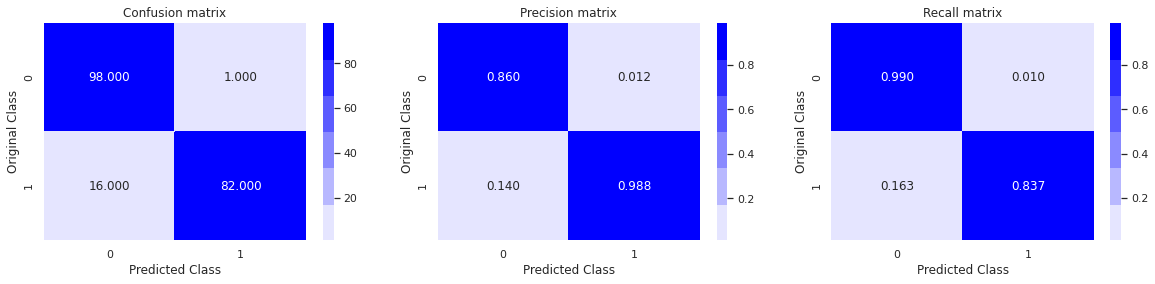

In [63]:
# printing the best value for F1 score, accuracy, ROC-AUC, Recall and a confuion matrix plot
knn_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels=y_train.values)

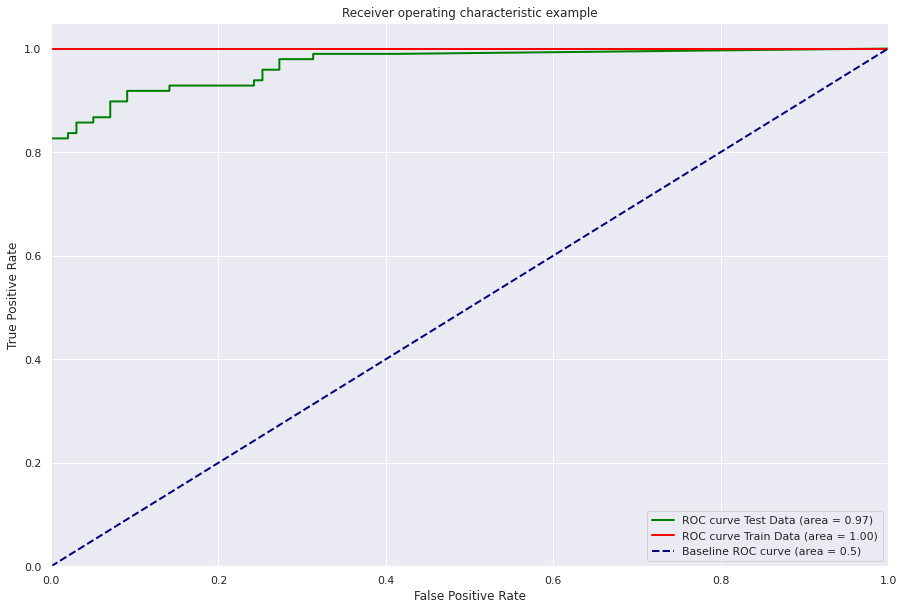

In [64]:
#Calibrate the model
from sklearn.calibration import CalibratedClassifierCV
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

#### Decision Trees Classifier

In [66]:
# Building an Decision Tree Classifier Model
from sklearn.tree import DecisionTreeClassifier


st=dt.now()

tuned_parameters = {'max_depth': np.arange(1,10,1),
                    'criterion': ['gini','entropy'],
                    'min_samples_split': np.arange(0.1,1.0,0.1),
                    'min_samples_leaf' : np.arange(1,10,1),
                    'min_weight_fraction_leaf' : [0.0,0.1,0.2,0.3,0.4],
                    'max_features': ['auto','sqrt','log2']} 

model = DecisionTreeClassifier(random_state=state)
rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=tuned_parameters, 
                                cv=3, scoring='roc_auc',
                                verbose=5,
                                n_jobs=-1,
                                random_state=state)

rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Time taken to complete random search:  0:00:00.238356


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished


In [67]:
# printing the value for best estimators, Best parameters, No of CrossValidation sets and Best Score
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=0.1,
                       min_weight_fraction_leaf=0.1, presort='deprecated',
                       random_state=48, splitter='best')

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'min_weight_fraction_leaf': 0.1, 'min_samples_split': 0.1, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 3, 'criterion': 'gini'}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 3

--------------------------
|        Best Score       |
--------------------------

Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:00:00.004340


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:00:00.002640


---------------------
|      F1 Score      |
---------------------

    0.8934010152284264


---------------------
|      Accuracy      |
---------------------

    0.8934010152284264


---------------------
|      Recall        |
---------------------

    0.8163265306122449


---------------------
|      ROC AUC       |
---------------------

    0.9443929086786229


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        99
           1       0.96      0.82      0.88        98

    accuracy                           0.89       197
   macro avg       0.90      0.89      0.89       197
weighted avg       0.90      0.89      0.89       197



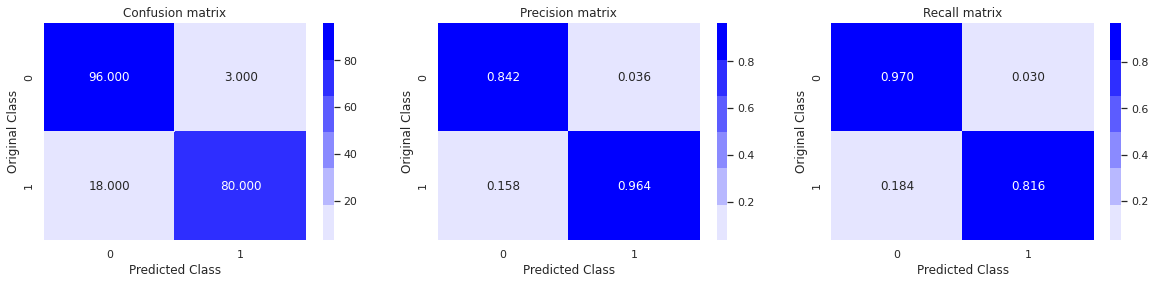

In [68]:
# printing the best value for F1 score, accuracy, ROC-AUC, Recall and a confuion matrix plot
dt_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels=y_train.values)

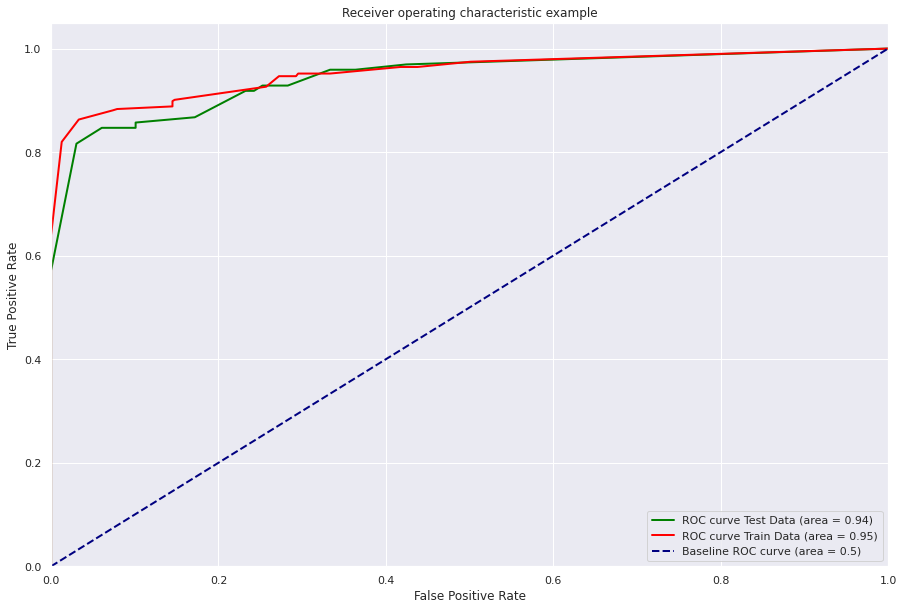

In [69]:
#Calibrate the model
from sklearn.calibration import CalibratedClassifierCV
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

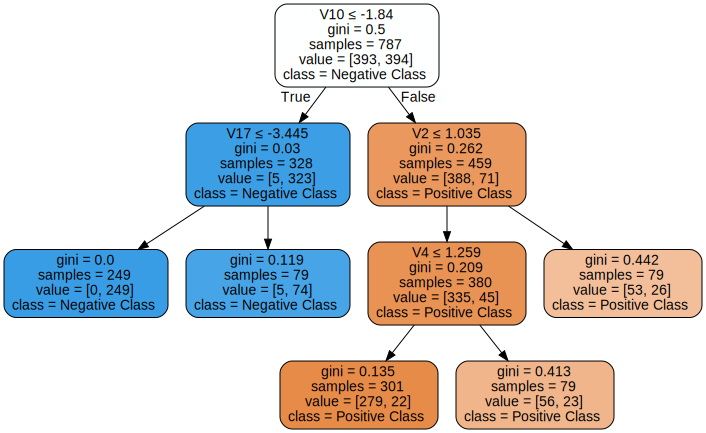

In [70]:
#Visualision the decision Tree
def visualize_tree(trained_clf, f_names, filename):
    from sklearn import tree
    import graphviz
    dot_data = tree.export_graphviz(decision_tree=trained_clf, out_file=None, max_depth=3, filled=True, rounded=True, special_characters=True, impurity=True, feature_names=f_names, class_names=['Positive Class','Negative Class'])  
    graph = graphviz.Source(dot_data)  
    graph.render(filename, format='png') 
    return graph

#Call the function above and pass a filename onto it.
f_names=[i for i in X_train.columns]

graph=visualize_tree(trained_model, f_names, 'Credit_Card_Tree.png')
graph

#### Linear SVM Classifier

In [72]:
## Building a SVM Classifier model
from sklearn.svm import SVC

st=dt.now()
tuned_parameters = {'C':np.logspace(-3,4,25), 
                    'gamma':np.logspace(-3,1,8)}

model = SVC(random_state=state)

rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=tuned_parameters, 
                                cv=3, scoring='roc_auc',
                                verbose=5,
                                n_jobs=-1,
                                random_state=state)
rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Time taken to complete random search:  0:00:00.764548


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.7s finished


In [73]:
# printing the value for best estimators, Best parameters, No of CrossValidation sets and Best Score
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	SVC(C=0.028729848333536655, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.003727593720314938, kernel='rbf', max_iter=-1, probability=False,
    random_state=48, shrinking=True, tol=0.001, verbose=False)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'gamma': 0.003727593720314938, 'C': 0.028729848333536655}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 3

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.9758539005814805



Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:00:00.032309


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:00:00.006220


---------------------
|      F1 Score      |
---------------------

    0.8832487309644669


---------------------
|      Accuracy      |
---------------------

    0.883248730964467


---------------------
|      Recall        |
---------------------

    0.7857142857142857


---------------------
|      ROC AUC       |
---------------------

    0.9649556792413936


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       0.82      0.98      0.89        99
           1       0.97      0.79      0.87        98

    accuracy                           0.88       197
   macro avg       0.90      0.88      0.88       197
weighted avg       0.90      0.88      0.88       197



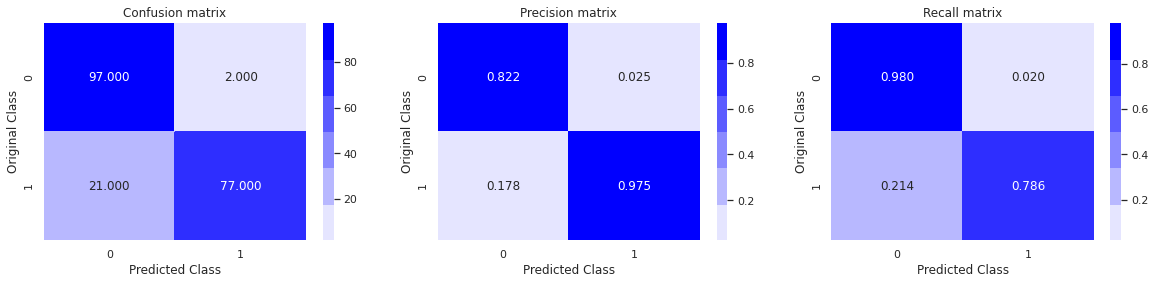

In [74]:
# printing the best value for F1 score, accuracy, ROC-AUC, Recall and a confuion matrix plot
svc_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels=y_train.values)

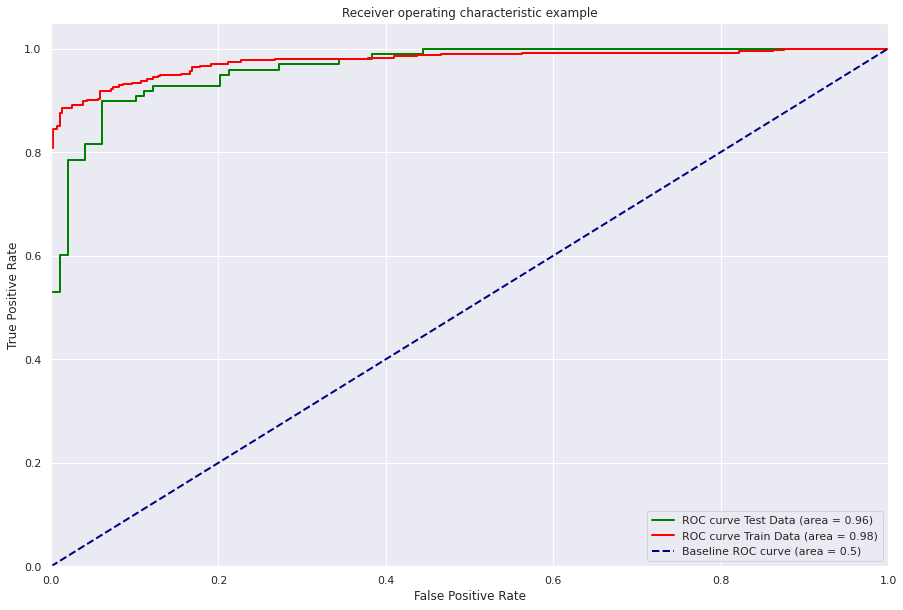

In [75]:
#Calibrate the model
from sklearn.calibration import CalibratedClassifierCV
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

#### Random Forest Classifier

In [77]:
## Building an Random Forest Model
from sklearn.ensemble import RandomForestClassifier

st=dt.now()
tuned_parameters = {'max_depth':[3,4,5,6,7,8,9,10],
                    'criterion':['gini','entropy'],
                    'min_samples_split':[2,3,5,7,9], 
                    'max_features':['auto','sqrt', 'log2'],
                    'min_samples_leaf':[1, 10, 25, 50, 75, 100],
                    'n_estimators':[10,20,30,40,50,60,80,100,500,1000,1500,2000,3000],
                    'max_leaf_nodes':[None, 10, 25, 50, 100, 500]}

model = RandomForestClassifier(random_state=state)
rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=tuned_parameters, 
                                cv=3, scoring='roc_auc',
                                verbose=5,
                                n_jobs=-1,
                                random_state=state)
rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   58.8s finished


Time taken to complete random search:  0:01:03.222365


In [78]:
# printing the value for best estimators, Best parameters, No of CrossValidation sets and Best Score
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=1500,
                       n_jobs=None, oob_score=False, random_state=48, verbose=0,
                       warm_start=False)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'n_estimators': 1500, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_leaf_nodes': None, 'max_features': 'log2', 'max_depth': 7, 'criterion': 'entropy'}

---------------------------------
|   No of CrossValidation sets   |
----------------------

Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:00:04.449563


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:00:00.184504


---------------------
|      F1 Score      |
---------------------

    0.9086294416243654


---------------------
|      Accuracy      |
---------------------

    0.9086294416243654


---------------------
|      Recall        |
---------------------

    0.8367346938775511


---------------------
|      ROC AUC       |
---------------------

    0.973922902494331


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       0.86      0.98      0.92        99
           1       0.98      0.84      0.90        98

    accuracy                           0.91       197
   macro avg       0.92      0.91      0.91       197
weighted avg       0.92      0.91      0.91       197



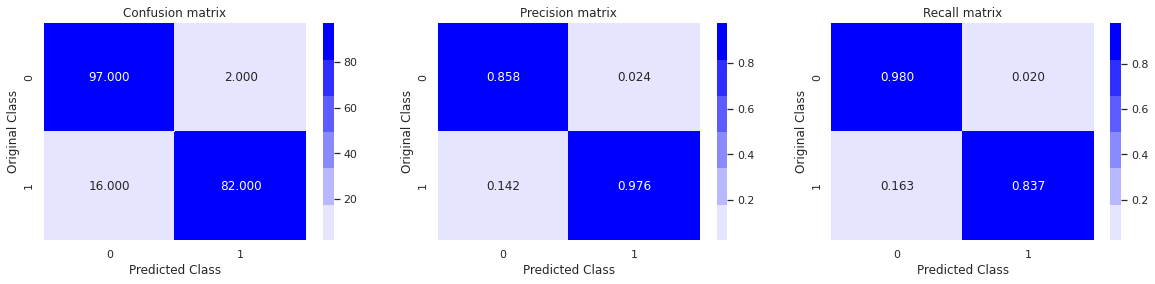

In [79]:
# printing the best value for F1 score, accuracy, ROC-AUC, Recall and a confuion matrix plot
rf_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels=y_train.values)

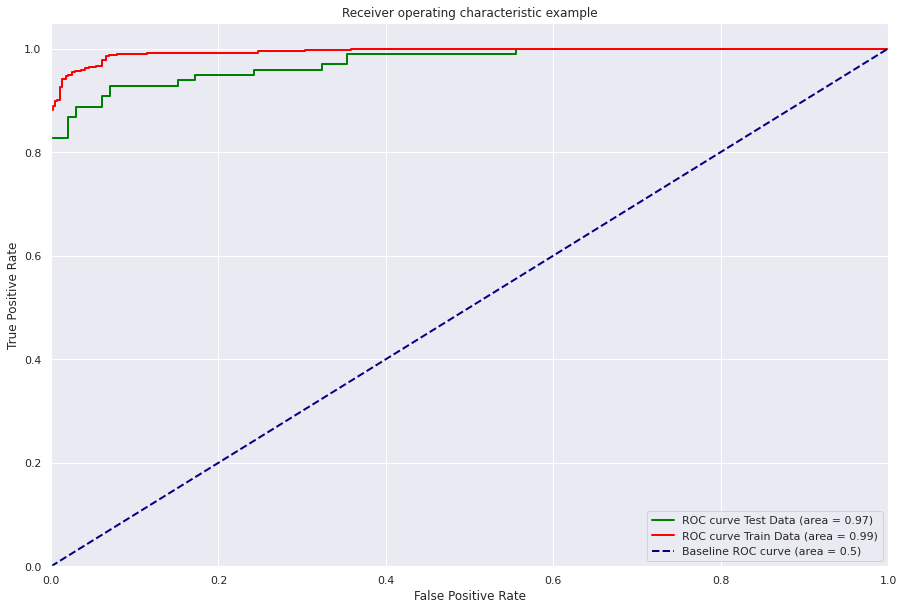

In [80]:
#Calibrate the model
from sklearn.calibration import CalibratedClassifierCV
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

#### XGBoost Classifier model

In [82]:
## Building an XGBoost Model
from xgboost import XGBClassifier

st=dt.now()
tuned_parameters = {'learning_rate':[0.1,0.01,0.001,0.0001],
                    'n_estimators':[10,25,50,100,250,500,650,750,850,1000,1500,2000,3000],
                    'subsample':[0.6,0.7,0.8],
                    'min_child_weight':[3,5,7,9],
                    'max_depth': [3,4,5,6,7,9,11,13,15,17,20,25,50],
                    'colsample_bytree':[0.6,0.7,0.8],
                    'gamma':[0,0.25,0.4,0.5,0.55,0.7,1]}

model = XGBClassifier(random_state=state)

rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=tuned_parameters, 
                                cv=3, scoring='roc_auc',
                                verbose=5,
                                n_jobs=-1,
                                random_state=state)
rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.5s finished


Time taken to complete random search:  0:00:14.811173


In [83]:
# printing the value for best estimators, Best parameters, No of CrossValidation sets and Best Score
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.25,
              learning_rate=0.01, max_delta_step=0, max_depth=17,
              min_child_weight=3, missing=None, n_estimators=850, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=48,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'subsample': 0.6, 'n_estimators': 850, 'min_child_weight': 3, 'max_depth': 17, 'learning_rate': 0.01, 'gamma': 0.25, 'colsample_bytree': 0.8}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 3

--------------------------
|

Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:00:01.206268


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:00:00.008832


---------------------
|      F1 Score      |
---------------------

    0.934010152284264


---------------------
|      Accuracy      |
---------------------

    0.934010152284264


---------------------
|      Recall        |
---------------------

    0.8775510204081632


---------------------
|      ROC AUC       |
---------------------

    0.9831993403421975


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       0.89      0.99      0.94        99
           1       0.99      0.88      0.93        98

    accuracy                           0.93       197
   macro avg       0.94      0.93      0.93       197
weighted avg       0.94      0.93      0.93       197



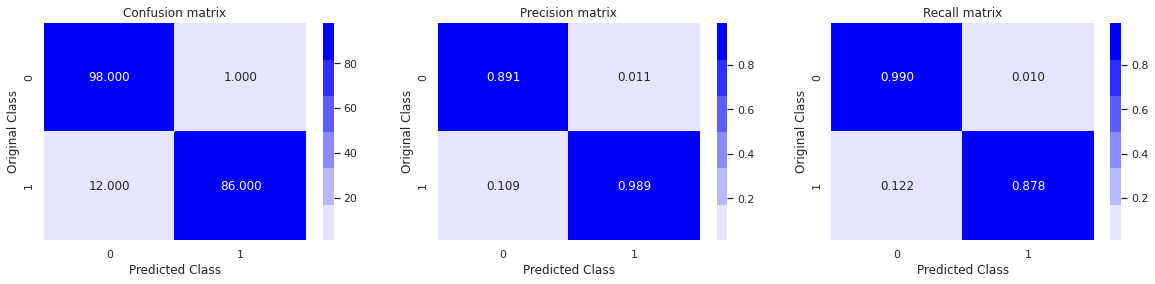

In [84]:
# printing the best value for F1 score, accuracy, ROC-AUC, Recall and a confuion matrix plot
xgb_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels=y_train.values)

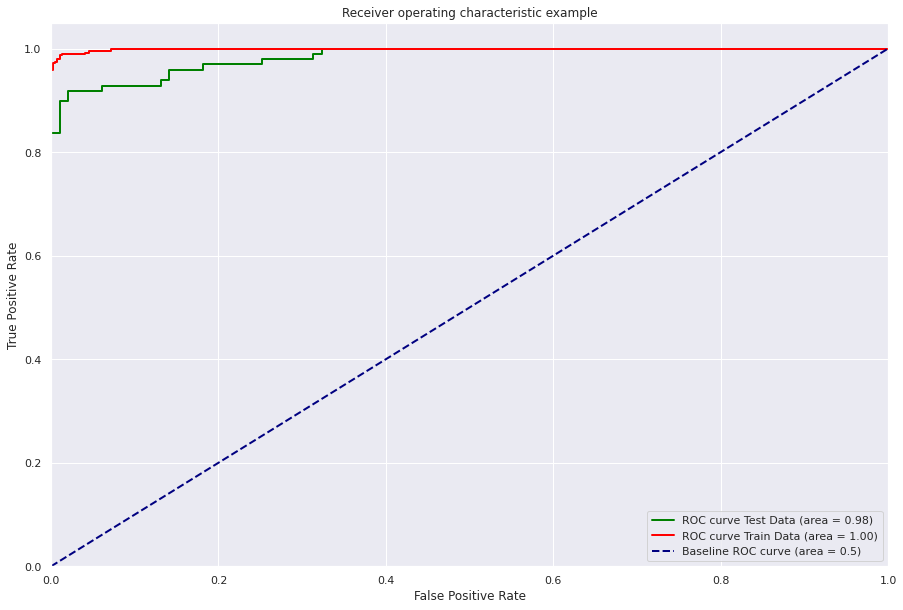

In [85]:
#Calibrate the model
from sklearn.calibration import CalibratedClassifierCV
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

Under Sampling:
1. Logistic Regression --
a. Accuracy: 92.3
b. Recall: 84.69
c. F1 Score: 92.3
d. ROC AUC: 99.02
    
2. Decision Tree --
a. Accuracy: 89.3
b. Recall: 81.6
c. F1 Score: 89.3
d. ROC AUC: 94.3
    
3. Random Forest --
a. Accuracy: 90.8
b. Recall: 83.6
c. F1 Score: 90.8
d. ROC AUC: 97.3
    
4. KNN --
a. Accuracy: 91.3
b. Recall: 83.6
c. F1 Score: 91.3
d. ROC AUC: 96.9
    
5. SVM --
a. Accuracy: 88.3
b. Recall: 78.5
c. F1 Score: 88.3
d. ROC AUC: 96.4
    
6. XGBoost --
a. Accuracy: 93.4
b. Recall: 87.7
c. F1 Score: 93.4
d. ROC AUC: 98.3


### Random OverSampling over the dataset

In [14]:
## Split the original imbalanced dataset into train and test set
from sklearn.model_selection import train_test_split

print("Shape of the original dataset: ", data.shape)

X=data.drop("Class", axis=1)
y=data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=state)

print('\nNumber of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])

Shape of the original dataset:  (284807, 30)

Number of data points in train data: 227845
Number of data points in test data: 56962


In [15]:
## Applying the Power Transformation
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns
power = PowerTransformer(method='yeo-johnson', standardize=True, copy = False)
data1 = power.fit_transform(X_train) 
X_train = pd.DataFrame(data1,columns = X_train.columns)

In [16]:
## Applying the Power Transformation
power = PowerTransformer(method='yeo-johnson', standardize=True, copy = False)
data2 = power.fit_transform(X_test) 
X_test = pd.DataFrame(data2,columns = X_test.columns)

In [17]:
#Get information about the class labels before applying Random OverSampling
print("Before oversampling, number of fraud transactions: ",y_train.value_counts()[1])
print("Before oversampling, number of non fraud transactions: ",y_train.value_counts()[0])

Before oversampling, number of fraud transactions:  394
Before oversampling, number of non fraud transactions:  227451


In [18]:
# Applying Oversampling on the dataset
from imblearn.over_sampling import RandomOverSampler
RandomOverSampler_obj = RandomOverSampler(sampling_strategy='minority',random_state=state)

#Adding synthetic points at this stage
X_train, y_train = RandomOverSampler_obj.fit_sample(X_train, y_train)

In [19]:
# checking the class distribution after over sampling
print("After oversampling, number of fraud transactions: ",sum(y_train==1))
print("After oversampling, number of non fraud transactions: ",sum(y_train==0))

After oversampling, number of fraud transactions:  227451
After oversampling, number of non fraud transactions:  227451


#### Logistic Regression Model

In [23]:
# importing the libraries required for running the model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from datetime import datetime as dt
from scipy import stats

In [40]:
## Building an Logistic Regression Model
st=dt.now()

tuned_parameters = {'C': stats.uniform(0,10000),
                    'penalty': ['l1','l2'] } #C values used for cross validation

model = LogisticRegression(n_jobs=-1, random_state=state)
rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=tuned_parameters, 
                                cv=5, scoring='roc_auc', 
                                n_jobs=-1,
                                verbose=5,
                                random_state=state)
rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    9.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.1s finished


Time taken to complete random search:  0:00:21.276709


In [41]:
# printing the value for best estimators, Best parameters, No of CrossValidation sets and Best Score
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	LogisticRegression(C=174.90270931152628, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=48, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'C': 174.90270931152628, 'penalty': 'l2'}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 5

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.9891602901616274



Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:00:11.149801


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:00:00.005810


---------------------
|      F1 Score      |
---------------------

    0.9727713212316983


---------------------
|      Accuracy      |
---------------------

    0.9727713212316983


---------------------
|      Recall        |
---------------------

    0.9081632653061225


---------------------
|      ROC AUC       |
---------------------

    0.9703714842718179


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.91      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962



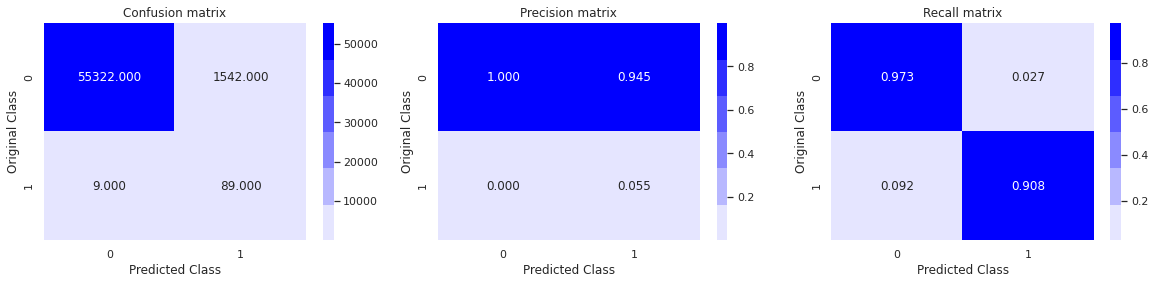

In [42]:
# printing the best value for F1 score, accuracy, ROC-AUC, Recall and a confuion matrix plot
log_reg_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels=y_train)

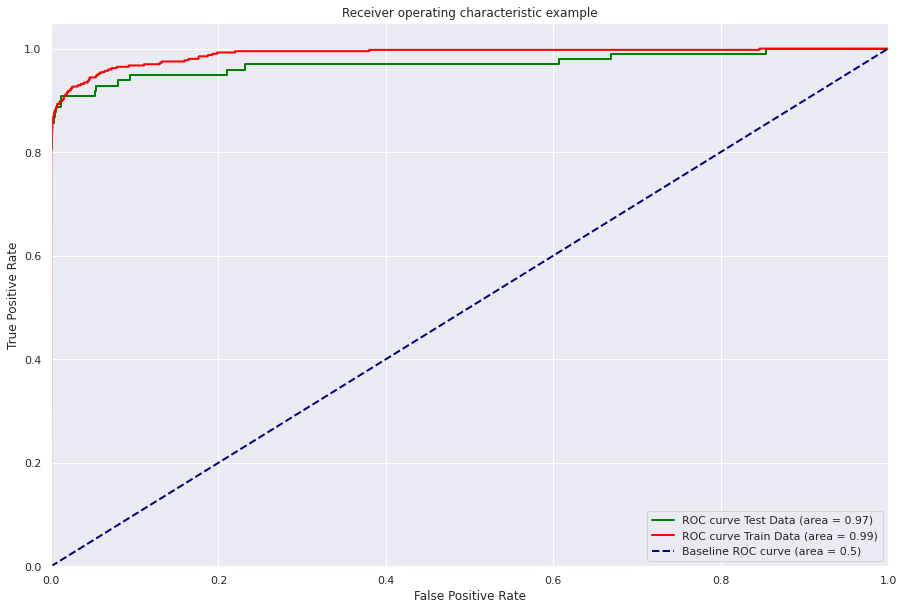

In [43]:
## Caliberating the model
from sklearn.calibration import CalibratedClassifierCV
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

#### Decision Trees Classifier

In [44]:
## building an Decision Tree Model
from sklearn.tree import DecisionTreeClassifier

st=dt.now()

tuned_parameters = {'max_depth': np.arange(1,10,1),
                    'criterion': ['gini','entropy'],
                    'min_samples_split': np.arange(0.1,1.0,0.1),
                    'min_samples_leaf' : np.arange(1,10,1),
                    'min_weight_fraction_leaf' : [0.0,0.1,0.2,0.3,0.4],
                    'max_features': ['auto','sqrt','log2']} 

model = DecisionTreeClassifier(random_state=state)
rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=tuned_parameters, 
                                cv=5, scoring='roc_auc', 
                                n_jobs=-1,
                                verbose=5,
                                random_state=state)
rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.6s finished


Time taken to complete random search:  0:00:19.796635


In [45]:
# printing the value for best estimators, Best parameters, No of CrossValidation sets and Best Score
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=0.1,
                       min_weight_fraction_leaf=0.1, presort='deprecated',
                       random_state=48, splitter='best')

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'min_weight_fraction_leaf': 0.1, 'min_samples_split': 0.1, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 3, 'criterion': 'gini'}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 5

--------------------------
|        Best Score       |
--------------------------

Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:00:00.949194


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:00:00.006697


---------------------
|      F1 Score      |
---------------------

    0.8929461746427443


---------------------
|      Accuracy      |
---------------------

    0.8929461746427443


---------------------
|      Recall        |
---------------------

    0.8775510204081632


---------------------
|      ROC AUC       |
---------------------

    0.9425988107679764


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     56864
           1       0.01      0.88      0.03        98

    accuracy                           0.89     56962
   macro avg       0.51      0.89      0.49     56962
weighted avg       1.00      0.89      0.94     56962



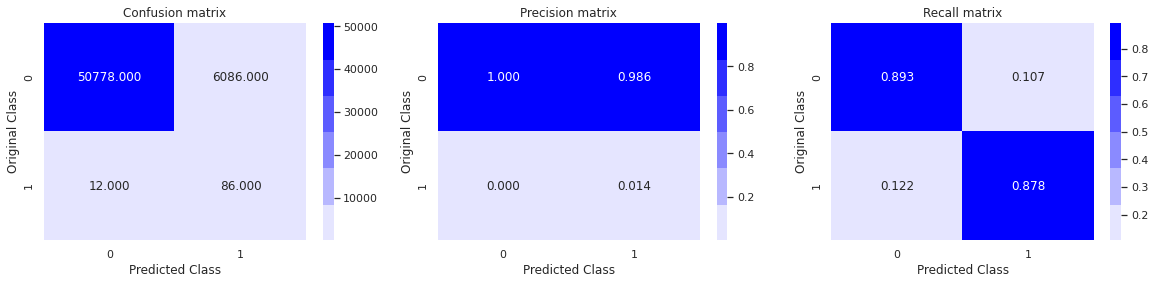

In [46]:
# printing the best value for F1 score, accuracy, ROC-AUC, Recall and a confuion matrix plot
dt_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels=y_train)

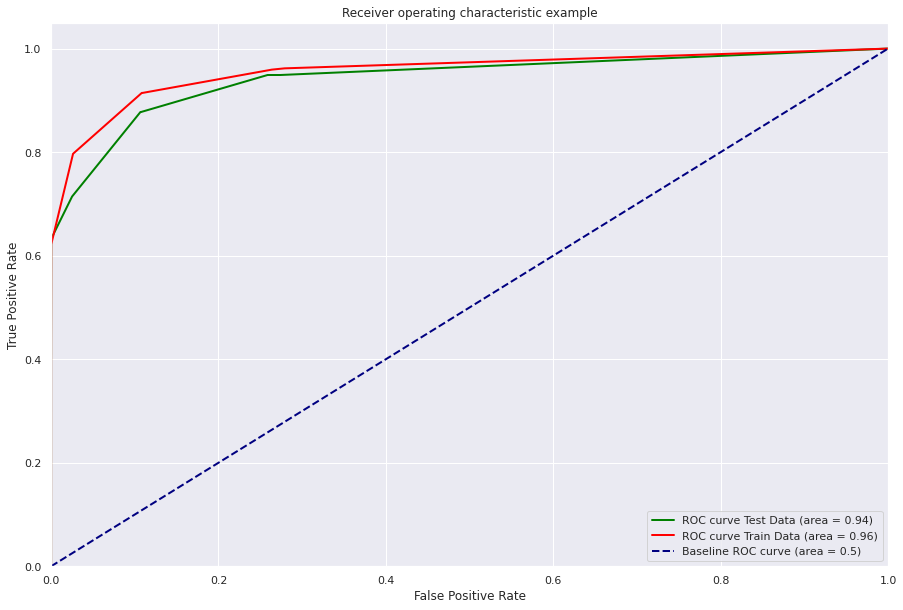

In [47]:
#Calibrate the model
from sklearn.calibration import CalibratedClassifierCV
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

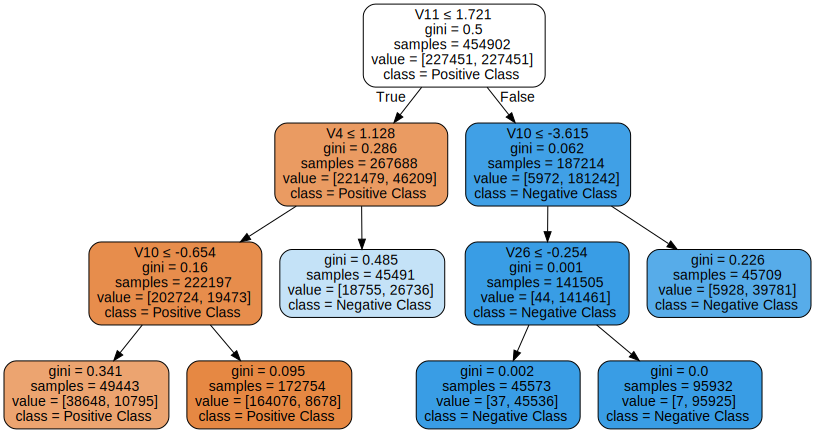

In [48]:
# Visualizing the Decision Tree 
def visualize_tree(trained_clf, f_names, filename):
    from sklearn import tree
    import graphviz
    dot_data = tree.export_graphviz(decision_tree=trained_clf, out_file=None, max_depth=3, filled=True, rounded=True, special_characters=True, impurity=True, feature_names=f_names, class_names=['Positive Class','Negative Class'])  
    graph = graphviz.Source(dot_data)  
    graph.render(filename, format='png') 
    return graph

#Call the function above and pass a filename onto it.
f_names=[i for i in X.columns]

graph=visualize_tree(trained_model, f_names, 'Credit_Card_Tree.png')
graph

#### Random Forest Classifier

In [50]:
## Building an random Forest Classifier model
from sklearn.ensemble import RandomForestClassifier

st=dt.now()
tuned_parameters = {'max_depth':[6,7,8,9],
                    'criterion':['gini','entropy'],
                    'min_samples_split':[2,3,5,7], 
                    'max_features':['auto','sqrt', 'log2'],
                    'min_samples_leaf':[1, 25, 50, 75, 100],
                    'n_estimators':[10,20,40,50,100,500],
                    'max_leaf_nodes':[ 25, 50, 100, 500]}

model = RandomForestClassifier(random_state=state)
rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=tuned_parameters, 
                                cv=5, scoring='roc_auc', 
                                n_jobs=-1,
                                verbose=5,
                                random_state=state)
rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 26.2min finished


Time taken to complete random search:  0:27:37.607947


In [51]:
# printing the value for best estimators, Best parameters, No of CrossValidation sets and Best Score
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=500, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=48, verbose=0,
                       warm_start=False)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'n_estimators': 40, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_leaf_nodes': 500, 'max_features': 'auto', 'max_depth': 9, 'criterion': 'entropy'}

---------------------------------
|   No of CrossValidation sets   |
------------------------------

Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:01:27.176652


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:00:00.202181


---------------------
|      F1 Score      |
---------------------

    0.9991573329588147


---------------------
|      Accuracy      |
---------------------

    0.9991573329588147


---------------------
|      Recall        |
---------------------

    0.8163265306122449


---------------------
|      ROC AUC       |
---------------------

    0.9693708870717674


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.82      0.77        98

    accuracy                           1.00     56962
   macro avg       0.86      0.91      0.88     56962
weighted avg       1.00      1.00      1.00     56962



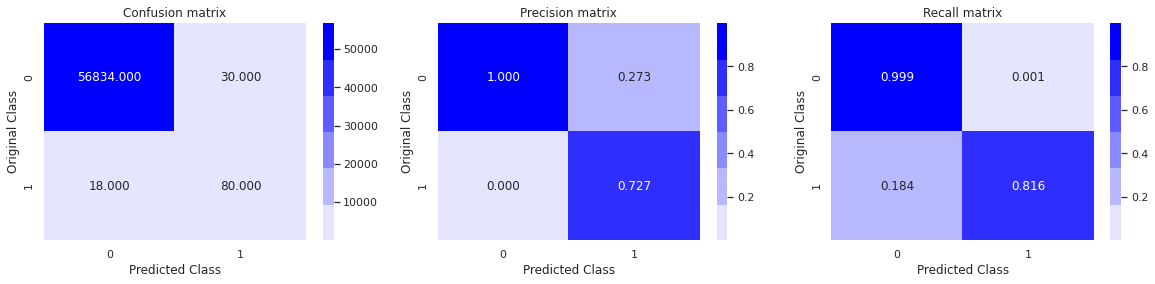

In [52]:
# printing the best value for F1 score, accuracy, ROC-AUC, Recall and a confuion matrix plot
rf_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels=y_train)

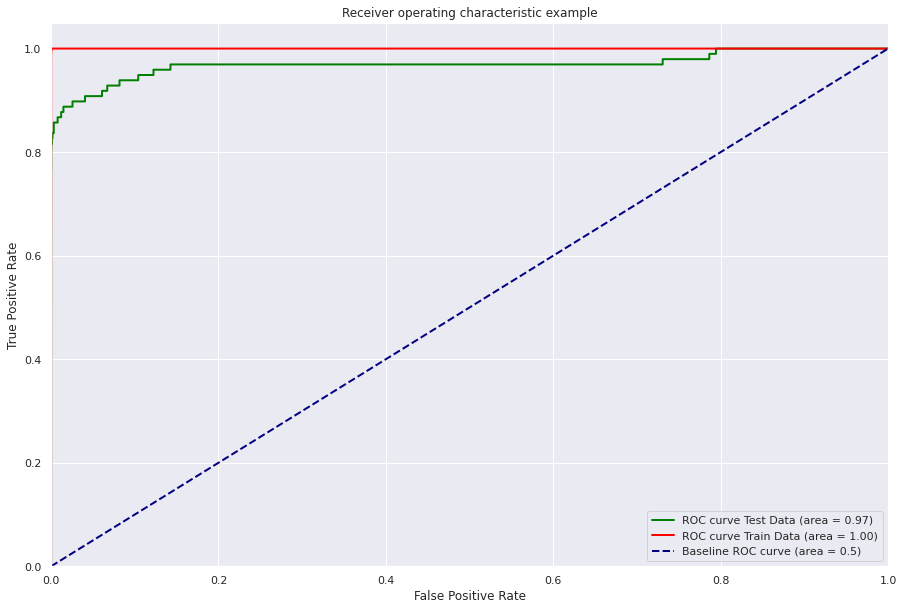

In [53]:
#Calibrate the model
from sklearn.calibration import CalibratedClassifierCV
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

####  XGBoost Classifier

In [24]:
## Building an XGBoost model
from xgboost import XGBClassifier

st=dt.now()
tuned_parameters = {'learning_rate':[0.1,0.01],
                    'n_estimators':[10,100,250,500,750],
                    'subsample':[0.6,0.7,0.8],
                    'min_child_weight':[3,5,7],
                    'max_depth': [6,7,9],
                    'colsample_bytree':[0.7,0.8],
                    'gamma':[0.5,1]}

model = XGBClassifier(random_state=state)
rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=tuned_parameters, 
                                cv=5, scoring='roc_auc', 
                                n_jobs=-1,
                                verbose=5,
                                random_state=state)
rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 49.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 233.4min finished


Time taken to complete random search:  4:06:46.133185


In [25]:
# printing the value for best estimators, Best parameters, No of CrossValidation sets and Best Score
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=5, missing=None, n_estimators=750, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=48,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'subsample': 0.6, 'n_estimators': 750, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.8}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 5

--------------------------
|        Be

Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:13:37.392072


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:00:01.351503


---------------------
|      F1 Score      |
---------------------

    0.9995435553526912


---------------------
|      Accuracy      |
---------------------

    0.9995435553526912


---------------------
|      Recall        |
---------------------

    0.8061224489795918


---------------------
|      ROC AUC       |
---------------------

    0.9690030204541016


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.81      0.86        98

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962



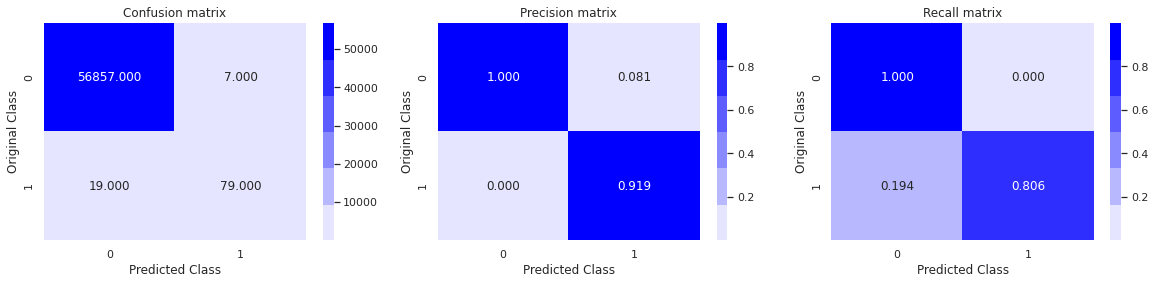

In [26]:
# printing the best value for F1 score, accuracy, ROC-AUC, Recall and a confuion matrix plot
xgb_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test.values, y_test, class_labels=y_train)

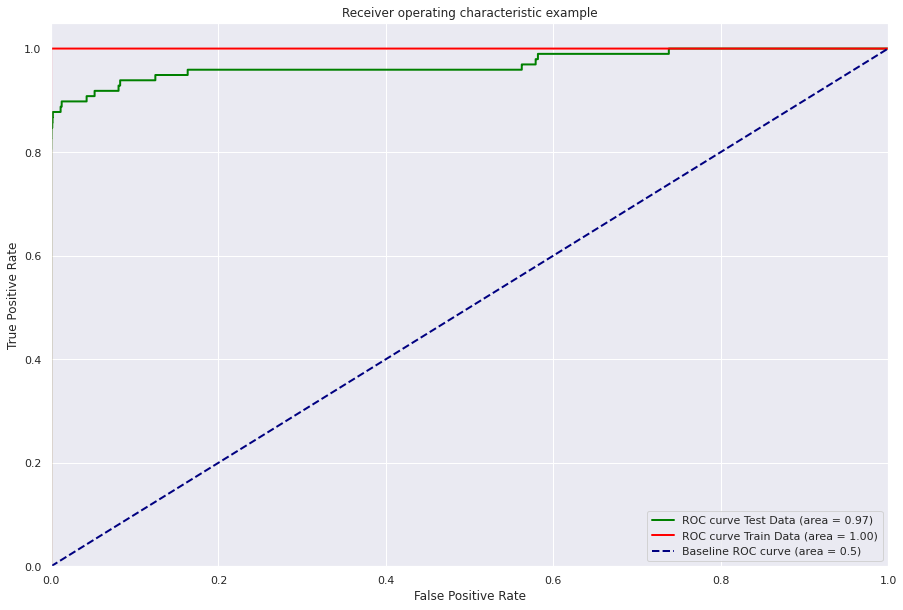

In [27]:
#Calibrate the model
from sklearn.calibration import CalibratedClassifierCV
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

Random OverSampling over the dataset
1. Logistic Regression --
a. Accuracy: 97.2
b. Recall: 90.8
c. F1 Score: 97.2
d. ROC AUC: 97.03
    
2. Decision Tree --
a. Accuracy: 89.2
b. Recall: 87.7
c. F1 Score: 89.2
d. ROC AUC: 94.2
    
3. Random Forest --
a. Accuracy: 99.9
b. Recall: 81.6
c. F1 Score: 99.9
d. ROC AUC: 96.9
    
4. XGBoost --
a. Accuracy: 99.9
b. Recall: 80.6
c. F1 Score: 99.9
d. ROC AUC: 96.9


### Using Oversampling technique SMOTE 

In [17]:
#  splitting the dataset into test and train
from sklearn.model_selection import train_test_split

print("Shape of the original dataset: ", data.shape)

X=data.drop("Class", axis=1)
y=data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=state)

print('\nNumber of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])

Shape of the original dataset:  (284807, 30)

Number of data points in train data: 227845
Number of data points in test data: 56962


In [18]:
## importing and making arrangement in order to use Power Transformation on the data
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns
power = PowerTransformer(method='yeo-johnson', standardize=True, copy = False)
data1 = power.fit_transform(X_train) 
X_train = pd.DataFrame(data1,columns = X_train.columns)

In [19]:
## Aplying the power sampling technique
power = PowerTransformer(method='yeo-johnson', standardize=True, copy = False)
data2 = power.fit_transform(X_test) 
X_test = pd.DataFrame(data2,columns = X_test.columns)

In [31]:
#Get information about the class labels before applying SMOTE
print("Before oversampling, number of fraud transactions: ",y_train.value_counts()[1])
print("Before oversampling, number of non fraud transactions: ",y_train.value_counts()[0])

Before oversampling, number of fraud transactions:  394
Before oversampling, number of non fraud transactions:  227451


In [20]:
## applying the SMOTE oversampling technique
from imblearn.over_sampling import SMOTE
smote_obj = SMOTE(sampling_strategy='minority',random_state=state)

#Adding synthetic points at this stage
X_train, y_train = smote_obj.fit_sample(X_train, y_train)

In [33]:
## checking the data distribution after applying SMOTE
print("After oversampling, number of fraud transactions: ",sum(y_train==1))
print("After oversampling, number of non fraud transactions: ",sum(y_train==0))

After oversampling, number of fraud transactions:  227451
After oversampling, number of non fraud transactions:  227451


#### Logistic Regression Model

In [22]:
## Building an Logistic regression model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from datetime import datetime as dt
from scipy import stats

st=dt.now()

tuned_parameters = {'C': stats.uniform(0,10000),
                    'penalty': ['l1','l2'] } #C values used for cross validation

model = LogisticRegression(n_jobs=-1, random_state=state)
rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=tuned_parameters, 
                                cv=5, scoring='roc_auc', 
                                n_jobs=-1,
                                verbose=5,
                                random_state=state)
rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.9s finished


Time taken to complete random search:  0:00:19.052554


In [46]:
# printing the value for best estimators, Best parameters, No of CrossValidation sets and Best Score
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	LogisticRegression(C=174.90270931152628, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=48, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'C': 174.90270931152628, 'penalty': 'l2'}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 5

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.9909740328176906



Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:00:25.197844


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:00:00.003894


---------------------
|      F1 Score      |
---------------------

    0.9742108774270566


---------------------
|      Accuracy      |
---------------------

    0.9742108774270566


---------------------
|      Recall        |
---------------------

    0.9081632653061225


---------------------
|      ROC AUC       |
---------------------

    0.9749594090590654


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.91      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.97      0.99     56962



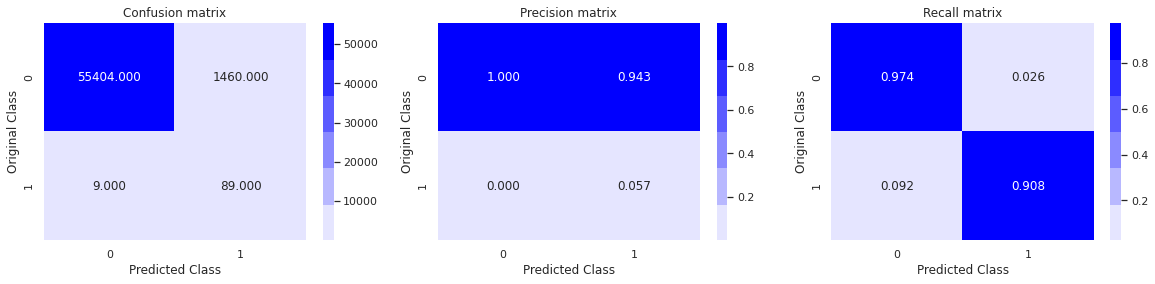

In [47]:
# printing the best value for F1 score, accuracy, ROC-AUC, Recall and a confuion matrix plot
log_reg_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels=y_train)

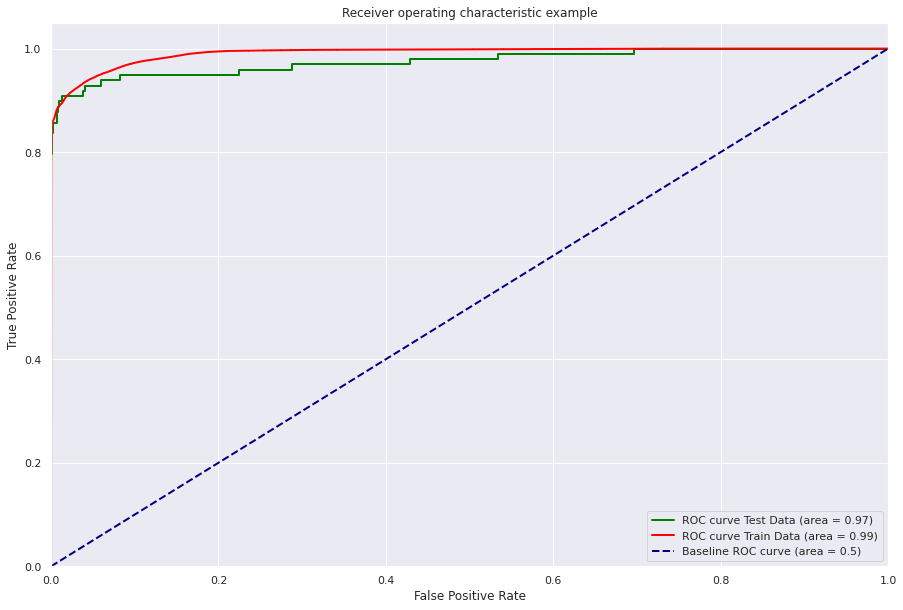

In [48]:
#Calibrate the model
from sklearn.calibration import CalibratedClassifierCV
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

#### KNN Classifier

In [34]:
## Building an KNN Classifier model
from sklearn.neighbors import KNeighborsClassifier

st=dt.now()

tuned_parameters = {'n_neighbors': [5,9,13],
                    'weights': ['uniform','distance']}

model = KNeighborsClassifier(n_jobs=-1, p=2, metric='minkowski')

rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=tuned_parameters, 
                                cv=5, scoring='roc_auc', 
                                n_jobs=-1,
                                verbose=5,
                                random_state=state)
rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 59.3min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 142.0min finished


Time taken to complete random search:  2:22:04.667130


In [35]:
# printing the value for best estimators, Best parameters, No of CrossValidation sets and Best Score
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                     weights='distance')

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'weights': 'distance', 'n_neighbors': 9}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 5

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.9996878448834663



Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:00:02.588647


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:06:10.379722


---------------------
|      F1 Score      |
---------------------

    0.9972613321161476


---------------------
|      Accuracy      |
---------------------

    0.9972613321161476


---------------------
|      Recall        |
---------------------

    0.8367346938775511


---------------------
|      ROC AUC       |
---------------------

    0.9328955660767402


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.37      0.84      0.51        98

    accuracy                           1.00     56962
   macro avg       0.68      0.92      0.76     56962
weighted avg       1.00      1.00      1.00     56962



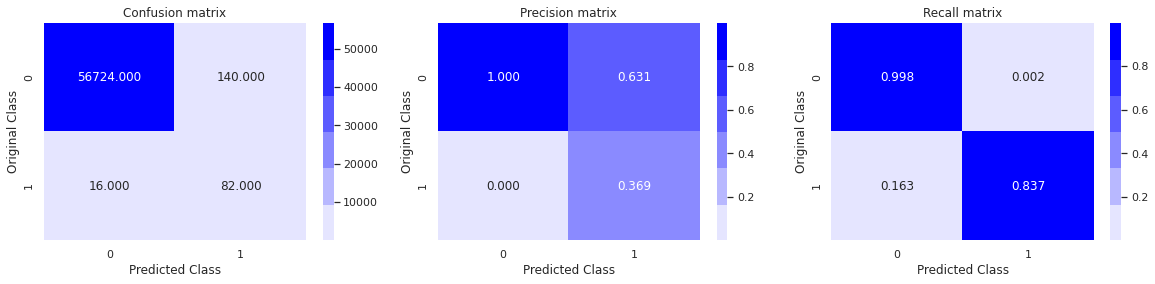

In [36]:
# printing the best value for F1 score, accuracy, ROC-AUC, Recall and a confuion matrix plot
knn_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels=y_train)

In [ ]:
#Calibrate the model
from sklearn.calibration import CalibratedClassifierCV
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

#### Decision Trees Classifier

In [49]:
## Building an Decision Tree Model
from sklearn.tree import DecisionTreeClassifier


st=dt.now()

tuned_parameters = {'max_depth': np.arange(1,10,1),
                    'criterion': ['gini','entropy'],
                    'min_samples_split': np.arange(0.1,1.0,0.1),
                    'min_samples_leaf' : np.arange(1,10,1),
                    'min_weight_fraction_leaf' : [0.0,0.1,0.2,0.3,0.4],
                    'max_features': ['auto','sqrt','log2']} 

model = DecisionTreeClassifier(random_state=state)
rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=tuned_parameters, 
                                cv=5, scoring='roc_auc', 
                                n_jobs=-1,
                                verbose=5,
                                random_state=state)
rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.2s finished


Time taken to complete random search:  0:00:19.415583


In [50]:
# printing the value for best estimators, Best parameters, No of CrossValidation sets and Best Score
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=0.1,
                       min_weight_fraction_leaf=0.1, presort='deprecated',
                       random_state=48, splitter='best')

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'min_weight_fraction_leaf': 0.1, 'min_samples_split': 0.1, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 3, 'criterion': 'gini'}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 5

--------------------------
|        Best Score       |
--------------------------

Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:00:01.068448


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:00:00.006414


---------------------
|      F1 Score      |
---------------------

    0.9846564376250834


---------------------
|      Accuracy      |
---------------------

    0.9846564376250834


---------------------
|      Recall        |
---------------------

    0.8163265306122449


---------------------
|      ROC AUC       |
---------------------

    0.9513358223846656


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.09      0.82      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.90      0.57     56962
weighted avg       1.00      0.98      0.99     56962



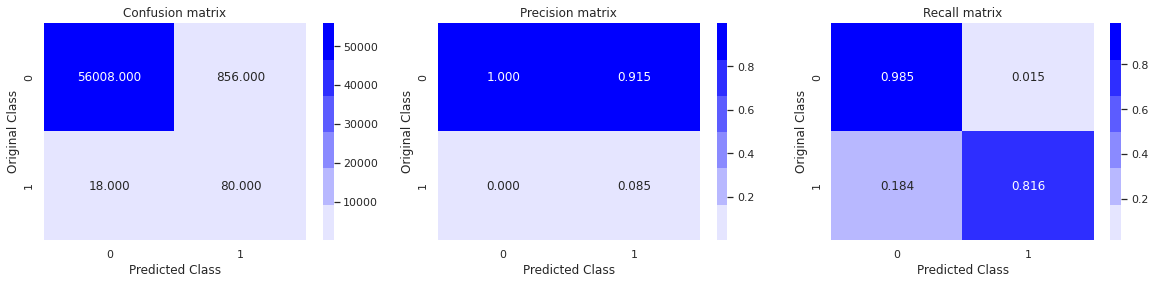

In [51]:
# printing the best value for F1 score, accuracy, ROC-AUC, Recall and a confuion matrix plot
dt_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels=y_train)

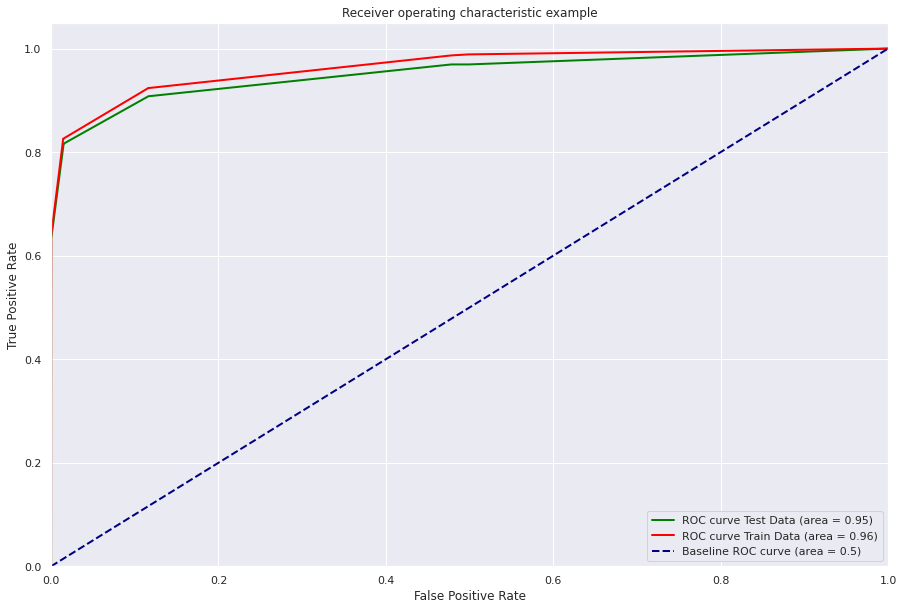

In [52]:
## caliberating the model
from sklearn.calibration import CalibratedClassifierCV
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

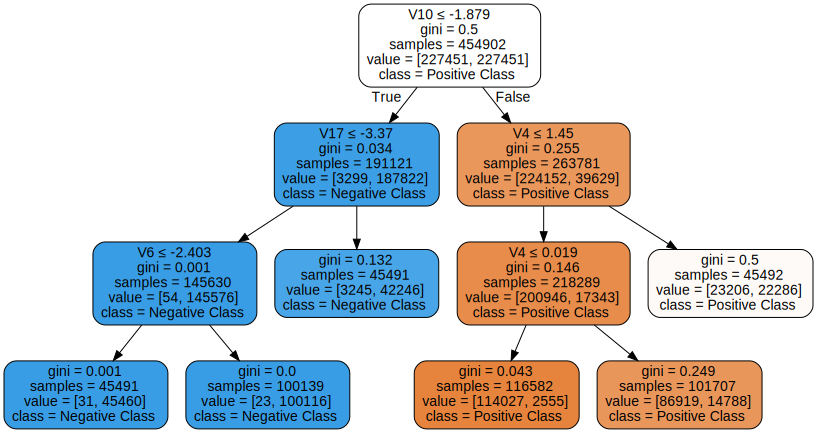

In [53]:
## Visualizing the model
def visualize_tree(trained_clf, f_names, filename):
    from sklearn import tree
    import graphviz
    dot_data = tree.export_graphviz(decision_tree=trained_clf, out_file=None, max_depth=3, filled=True, rounded=True, special_characters=True, impurity=True, feature_names=f_names, class_names=['Positive Class','Negative Class'])  
    graph = graphviz.Source(dot_data)  
    graph.render(filename, format='png') 
    return graph

#Call the function above and pass a filename onto it.
f_names=[i for i in X.columns]

graph=visualize_tree(trained_model, f_names, 'Credit_Card_Tree.png')
graph

#### Random Forest

In [55]:
## building an random Forest model
from sklearn.ensemble import RandomForestClassifier

st=dt.now()
tuned_parameters = {'max_depth':[6,7,8,9],
                    'criterion':['gini','entropy'],
                    'min_samples_split':[2,3,5], 
                    'max_features':['auto','sqrt'],
                    'min_samples_leaf':[10, 25, 50, 75],
                    'n_estimators':[5,30,50,80,100],
                    'max_leaf_nodes':[50, 100, 500]}

model = RandomForestClassifier(random_state=state)
rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=tuned_parameters, 
                                cv=5, scoring='roc_auc', 
                                n_jobs=-1,
                                verbose=5,
                                random_state=state)
rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 39.1min finished


Time taken to complete random search:  0:40:20.282884


In [56]:
# printing the value for best estimators, Best parameters, No of CrossValidation sets and Best Score
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=100, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=48, verbose=0,
                       warm_start=False)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'n_estimators': 30, 'min_samples_split': 2, 'min_samples_leaf': 50, 'max_leaf_nodes': 100, 'max_features': 'auto', 'max_depth': 9, 'criterion': 'entropy'}

---------------------------------
|   No of CrossValidation sets   |
----------------------------

Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:01:10.850239


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:00:00.126365


---------------------
|      F1 Score      |
---------------------

    0.9975773322565921


---------------------
|      Accuracy      |
---------------------

    0.9975773322565921


---------------------
|      Recall        |
---------------------

    0.8673469387755102


---------------------
|      ROC AUC       |
---------------------

    0.9766593117269418


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.40      0.87      0.55        98

    accuracy                           1.00     56962
   macro avg       0.70      0.93      0.78     56962
weighted avg       1.00      1.00      1.00     56962



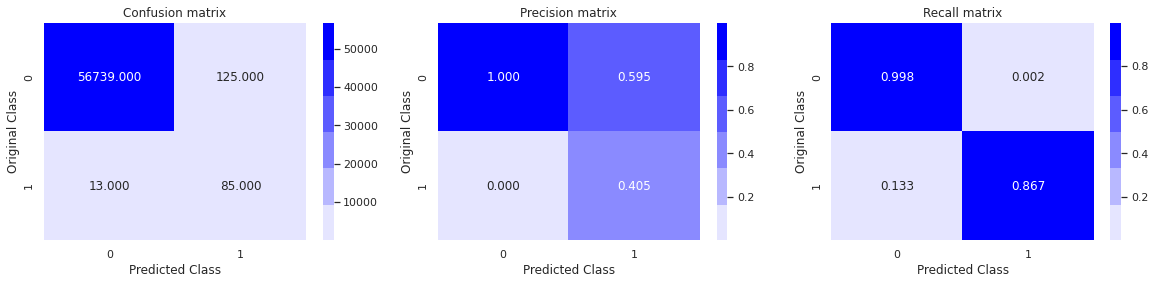

In [57]:
# printing the best value for F1 score, accuracy, ROC-AUC, Recall and a confuion matrix plot
rf_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels=y_train)

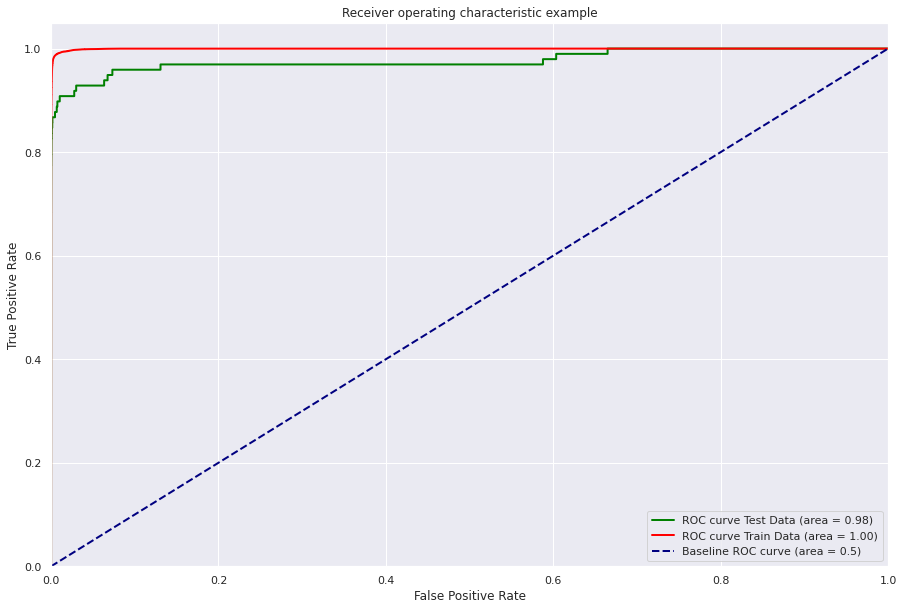

In [58]:
#Calibrate the model
from sklearn.calibration import CalibratedClassifierCV
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

#### XGBoost Classifier

In [ ]:
## Building an XG BOOST model
from xgboost import XGBClassifier

st=dt.now()
tuned_parameters = {'learning_rate':[0.1,0.01],
                    'n_estimators':[250,500,750],
                    'max_depth': [6,7,9]}

model = XGBClassifier(random_state=state)
rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=tuned_parameters, 
                                cv=5, scoring='roc_auc', 
                                n_jobs=-1,
                                verbose=5,
                                random_state=state)
rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
print_grid_search_attributes(rsearch_cv)

In [ ]:
xgb_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test.values, y_test, class_labels=y_train)

In [ ]:
#Calibrate the model
from sklearn.calibration import CalibratedClassifierCV
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

Using Oversampling technique SMOTE
1. Logistic Regression --
a. Accuracy: 97.4
b. Recall: 90.8
c. F1 Score: 97.4
d. ROC AUC: 97.4
 
2. SVM --
a. Accuracy: 99.7
b. Recall: 83.6
c. F1 Score: 99.7
d. ROC AUC: 93.2
    
3. Decision Tree --
a. Accuracy: 98.4
b. Recall: 81.6
c. F1 Score: 98.4
d. ROC AUC: 95.1
    
4. Random Forest --
a. Accuracy: 99.7
b. Recall: 86.7
c. F1 Score: 99.7
d. ROC AUC: 97.6

### Using Over sampling technique ADASYN over the unbalanced dataset

In [12]:
## Split the original imbalanced dataset into train and test set
from sklearn.model_selection import train_test_split

print("Shape of the original dataset: ", data.shape)

X=data.drop("Class", axis=1)
y=data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=state)

print('\nNumber of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])

Shape of the original dataset:  (284807, 30)

Number of data points in train data: 227845
Number of data points in test data: 56962


In [13]:
## importing the libraries in order to use Power Transformation on the dataset
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns
power = PowerTransformer(method='yeo-johnson', standardize=True, copy = False)
data1 = power.fit_transform(X_train) 
X_train = pd.DataFrame(data1,columns = X_train.columns)

In [14]:
# Applying power transformation on the dataset
power = PowerTransformer(method='yeo-johnson', standardize=True, copy = False)
data2 = power.fit_transform(X_test) 
X_test = pd.DataFrame(data2,columns = X_test.columns)

In [15]:
#Get information about the class labels before applying ADASYN
print("Before oversampling, number of fraud transactions: ",y_train.value_counts()[1])
print("Before oversampling, number of non fraud transactions: ",y_train.value_counts()[0])

Before oversampling, number of fraud transactions:  394
Before oversampling, number of non fraud transactions:  227451


In [18]:
## Data Oversampling using ADASYN
from imblearn.over_sampling import ADASYN
adasyn_obj = ADASYN(sampling_strategy='minority',random_state=state)

#Adding synthetic points at this stage
X_train, y_train = adasyn_obj.fit_sample(X_train, y_train)

In [19]:
#Get information about the class labels after applying ADASYN
print("After oversampling, number of fraud transactions: ",sum(y_train==1))
print("After oversampling, number of non fraud transactions: ",sum(y_train==0))

After oversampling, number of fraud transactions:  227475
After oversampling, number of non fraud transactions:  227451


#### Logistic Regression Classifier

In [20]:
## Building an Logistic Regression Model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from datetime import datetime as dt
from scipy import stats

st=dt.now()

tuned_parameters = {'C': stats.uniform(0,10000),
                    'penalty': ['l1','l2'] } #C values used for cross validation

model = LogisticRegression(n_jobs=-1, random_state=state)
rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=tuned_parameters, 
                                cv=5, scoring='roc_auc', 
                                n_jobs=-1,
                                verbose=5,
                                random_state=state)
rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    9.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.0s finished


Time taken to complete random search:  0:00:20.607893


In [21]:
# printing the value for best estimators, Best parameters, No of CrossValidation sets and Best Score
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	LogisticRegression(C=174.90270931152628, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=48, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'C': 174.90270931152628, 'penalty': 'l2'}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 5

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.9543034379373113



Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:00:10.969948


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:00:00.005590


---------------------
|      F1 Score      |
---------------------

    0.9093079596924265


---------------------
|      Accuracy      |
---------------------

    0.9093079596924265


---------------------
|      Recall        |
---------------------

    0.9387755102040817


---------------------
|      ROC AUC       |
---------------------

    0.9693260252891251


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     56864
           1       0.02      0.94      0.03        98

    accuracy                           0.91     56962
   macro avg       0.51      0.92      0.49     56962
weighted avg       1.00      0.91      0.95     56962



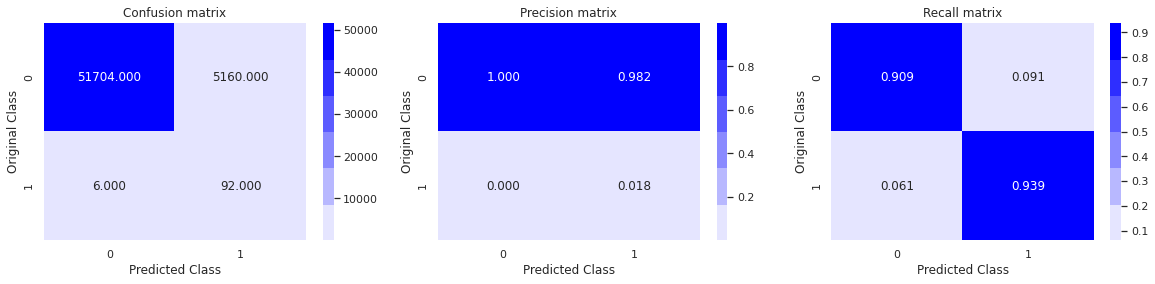

In [22]:
# printing the best value for F1 score, accuracy, ROC-AUC, Recall and a confuion matrix plot
log_reg_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels=y_train)

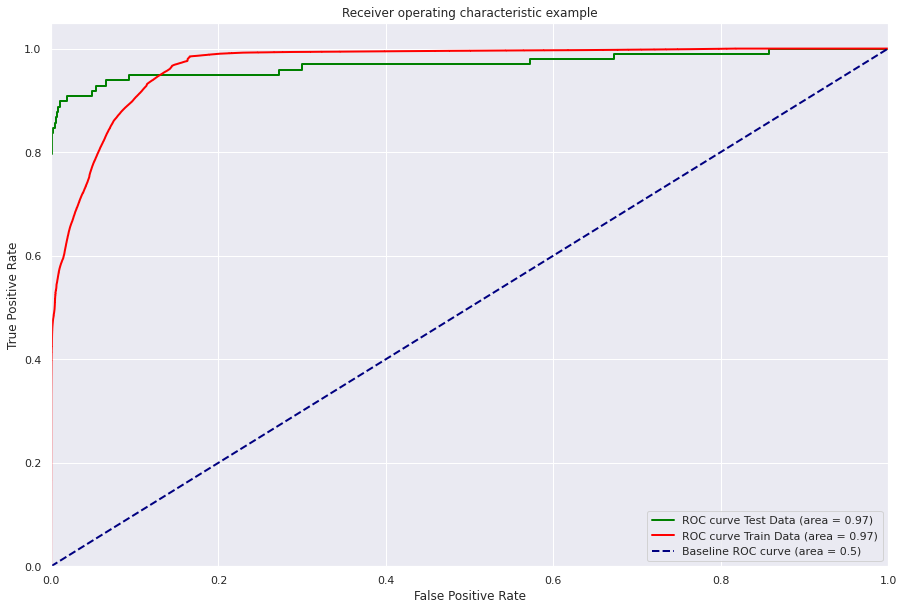

In [23]:
#Calibrate the model
from sklearn.calibration import CalibratedClassifierCV
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

#### Decision Trees Classifier

In [24]:
## Building an Decision Tree Model
from sklearn.tree import DecisionTreeClassifier


st=dt.now()

tuned_parameters = {'max_depth': np.arange(1,10,1),
                    'criterion': ['gini','entropy'],
                    'min_samples_split': np.arange(0.1,1.0,0.1),
                    'min_samples_leaf' : np.arange(1,10,1),
                    'min_weight_fraction_leaf' : [0.0,0.1,0.2,0.3,0.4],
                    'max_features': ['auto','sqrt','log2']} 

model = DecisionTreeClassifier(random_state=state)
rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=tuned_parameters, 
                                cv=5, scoring='roc_auc', 
                                n_jobs=-1,
                                verbose=5,
                                random_state=state)
rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.4s finished


Time taken to complete random search:  0:00:28.948276


In [25]:
# printing the value for best estimators, Best parameters, No of CrossValidation sets and Best Score
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=0.1,
                       min_weight_fraction_leaf=0.1, presort='deprecated',
                       random_state=48, splitter='best')

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'min_weight_fraction_leaf': 0.1, 'min_samples_split': 0.1, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 3, 'criterion': 'gini'}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 5

--------------------------
|        Best Score       |
--------------------------

Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:00:01.432489


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:00:00.007681


---------------------
|      F1 Score      |
---------------------

    0.8277097012043116


---------------------
|      Accuracy      |
---------------------

    0.8277097012043116


---------------------
|      Recall        |
---------------------

    0.8571428571428571


---------------------
|      ROC AUC       |
---------------------

    0.9431305126158512


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     56864
           1       0.01      0.86      0.02        98

    accuracy                           0.83     56962
   macro avg       0.50      0.84      0.46     56962
weighted avg       1.00      0.83      0.90     56962



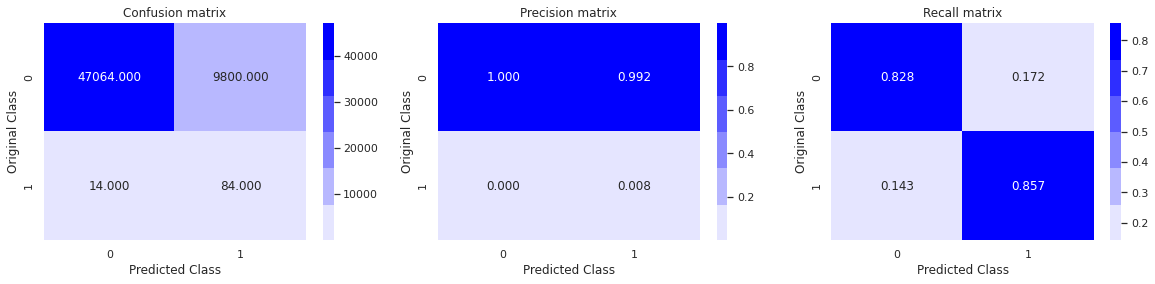

In [26]:
# printing the best value for F1 score, accuracy, ROC-AUC, Recall and a confuion matrix plot
dt_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels=y_train)

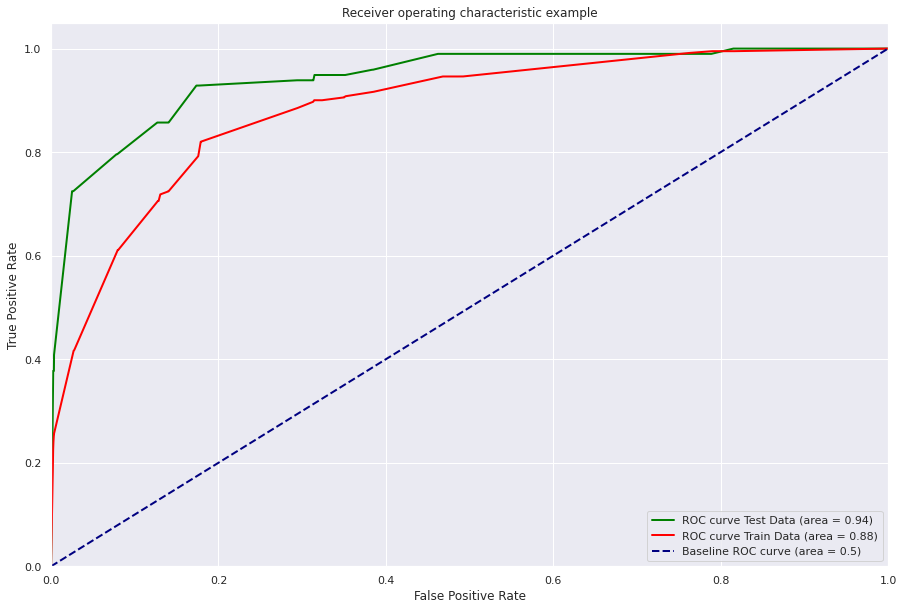

In [27]:
#Calibrate the model
from sklearn.calibration import CalibratedClassifierCV
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

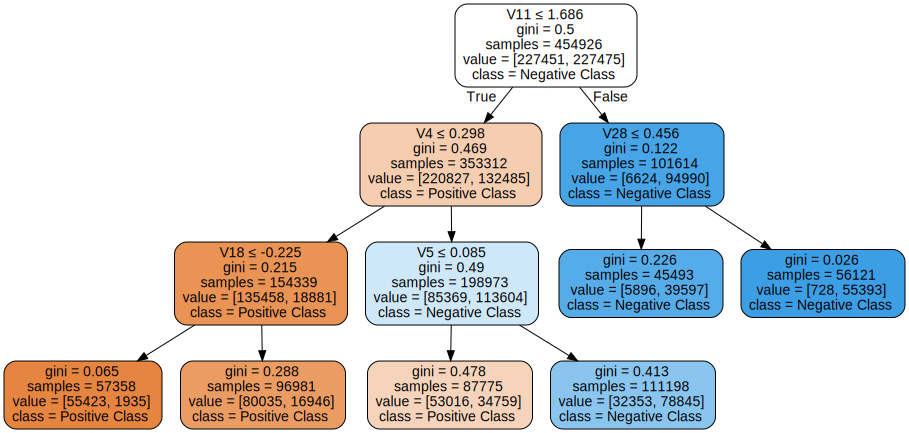

In [28]:
## Visualizing the Decision Tree
def visualize_tree(trained_clf, f_names, filename):
    from sklearn import tree
    import graphviz
    dot_data = tree.export_graphviz(decision_tree=trained_clf, out_file=None, max_depth=3, filled=True, rounded=True, special_characters=True, impurity=True, feature_names=f_names, class_names=['Positive Class','Negative Class'])  
    graph = graphviz.Source(dot_data)  
    graph.render(filename, format='png') 
    return graph

#Call the function above and pass a filename onto it.
f_names=[i for i in X.columns]

graph=visualize_tree(trained_model, f_names, 'Credit_Card_Tree.png')
graph

#### Random Forest Classifier

In [30]:
## Building an random Forest Model
from sklearn.ensemble import RandomForestClassifier

st=dt.now()
tuned_parameters = {'max_depth':[6,7,8,9],
                    'criterion':['gini','entropy'],
                    'min_samples_split':[2,3,5], 
                    'max_features':['auto','sqrt'],
                    'min_samples_leaf':[10, 25, 50, 75],
                    'n_estimators':[5,30,50,80,100],
                    'max_leaf_nodes':[50, 100, 500]}

model = RandomForestClassifier(random_state=state)
rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=tuned_parameters, 
                                cv=5, scoring='roc_auc', 
                                n_jobs=-1,
                                verbose=5,
                                random_state=state)
rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 52.8min finished


Time taken to complete random search:  0:54:33.229656


In [31]:
# printing the value for best estimators, Best parameters, No of CrossValidation sets and Best Score
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=100, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=48, verbose=0,
                       warm_start=False)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'n_estimators': 30, 'min_samples_split': 2, 'min_samples_leaf': 50, 'max_leaf_nodes': 100, 'max_features': 'auto', 'max_depth': 9, 'criterion': 'entropy'}

---------------------------------
|   No of CrossValidation sets   |
----------------------------

Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:01:44.593199


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:00:00.172402


---------------------
|      F1 Score      |
---------------------

    0.9806888803061691


---------------------
|      Accuracy      |
---------------------

    0.9806888803061691


---------------------
|      Recall        |
---------------------

    0.8979591836734694


---------------------
|      ROC AUC       |
---------------------

    0.9740957300196387


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.90      0.14        98

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.56     56962
weighted avg       1.00      0.98      0.99     56962



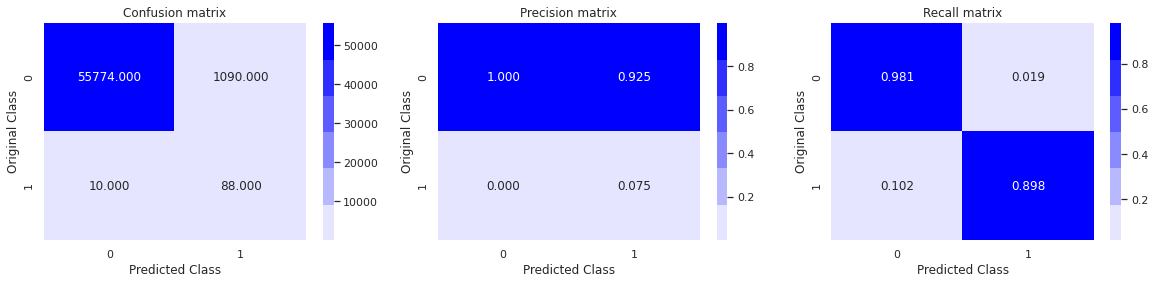

In [32]:
# printing the best value for F1 score, accuracy, ROC-AUC, Recall and a confuion matrix plot
rf_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels=y_train)

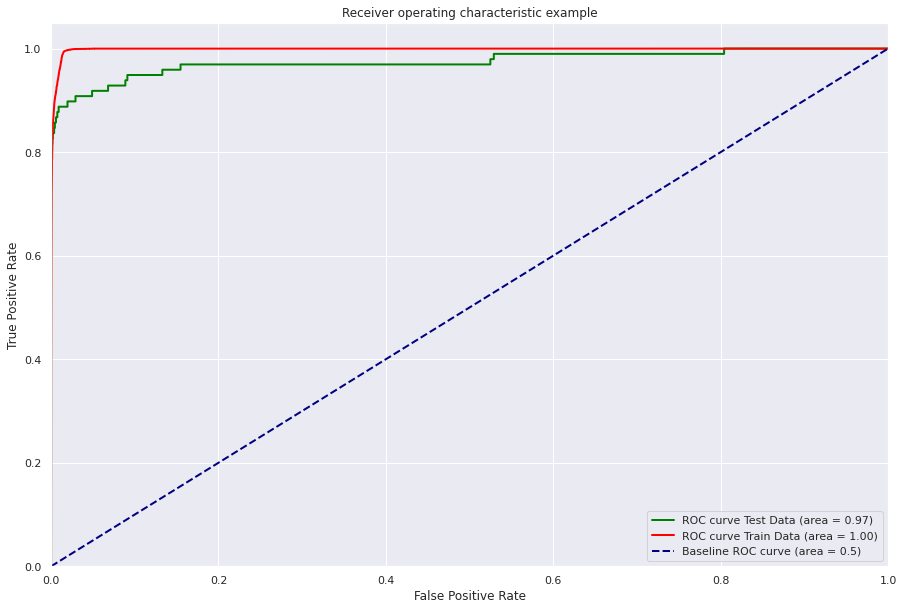

In [33]:
#Calibrate the model
from sklearn.calibration import CalibratedClassifierCV
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

Using Over sampling technique ADASYN over the unbalanced dataset
1. Logistic Regression --
a. Accuracy: 90.9
b. Recall: 93.87
c. F1 Score: 90.9
d. ROC AUC: 96.9
    
2. Decision Tree --
a. Accuracy: 82.7
b. Recall: 85.7
c. F1 Score: 82.7
d. ROC AUC: 94.3
    
3. Random Forest --
a. Accuracy: 98.06
b. Recall: 89.79
c. F1 Score: 98.06
d. ROC AUC: 97.4

Hence from the above codes we can see that 
1. No Sampling: If we don't do the sampling even though the accuracy is good but the recall is very bad. 
2. UnderSampling: With respect to Under Sampling technique even though the output which we getting is good, but there is huge loos of data in it, 
3. Random OverSampling: When we come to random over sampling we are not creating any new datapoints we are just repeting the same datapoints again and again
4. SMOTE: with respect to SMOTE we are actually creating new datapoints with respect to minority class, and the output which we are getting is slightly good compared to other.
5. ADASYN: With respect to ADASYN the process is similar to SMOTE but here it also takes density into issue with respect to minority class and it focuses on the datapoints which are hard to predict.

With respect to Logistic Regression with ADASYN sampling technique we are getting good Recall score.

with respect to Logistic Regression with SMOTE sampling technique we are getting good Recall score and good accuracy value also.

With respect to all other techniques SMOTE and ADASYS sampling technique we get good result compared to all other sampling techniques. Where as without sampling the result is worst.